____________________

### <center>Especialização em Inteligência Artificial - IFMG-OP</center>
### <center>Análise e Previsão de Séries Temporais</center>
#### <center>Prof. Carlos Severiano - Aluno: Fernando dos Santos Alves Fernandes</center>

____________________

## <center>Previsão da Evapotranspiração de Referência (ETo)</center>

### Introdução

Evapotranspiração é o processo pelo qual uma lavoura "perde" água para atmosfera. Consiste na ocorrência dos processos de evaporação e transpiração simultaneamente. Enquanto a evaporação é a passagem da água do estado líquido para o estado gasoso (vapor) a partir de qualquer superfície (lagos, rios, pavimentos, solo e área de vegetação), a transpiração é o processo de "perda" de água que ocorre a partir das folhas, flores, caules e raízes de uma vegetação.<br>
Os principais fatores que afetam o processo de evapotranspiração são:
* parâmetros climáticos (radiação, temperatura do ar, umidade relativa do ar, velocidade do vento);
* fatores relacionados ao tipo de cultivo (variedade da planta, estágio de desenvolvimento, cobertura do solo, características das raízes);
* condições ambientais e de manejo do solo (salinidade do solo, fertilidade do solo, limitações no uso de fertilizantes, ausência de controle de doenças);

Fig. 1 - Evapotranspiração, de acordo com os fatores que afetam seu cálculo.

![Fatores que afetam as ETos](images/fatores-ET.PNG)

Fig. 2 - Relação entre as Evapotranspirações.

![Relação entre evapotranspirações](images/fatores-ET-1.PNG)

Fig. 3 - Equação FAO* Penman-Monteith para cálculo da ETo.

![Equação FAO Penman-Monteith](images/Penman-Monteith-equation.PNG)

[*Food and Agriculture Organization of The United Nations](https://www.fao.org) ([No Brasil, desde 1949.](https://www.fao.org/brasil/pt/))

onde: 

- ETo - reference evapotranspiration [mm.day-1]
- Rn - net radiation at the crop surface [MJ.m-2.day-1]
- G - soil heat flux density [MJ.m-2/day]
- T - mean daily air temperatura at 2 m height [C]
- u2 - wind speed at 2 m height [m.s-1]
- es - saturation vapour pressure [kPa]
- ea - actual vapour pressure [kPa]
- (es - ea) - saturation vapour pressure deficit [kPa]
- delta - slope vapour pressure curve [kPa.C-1]
- gama - psychrometric constant [kPa.C-1]

Vantagens:

- Referência para comparação da ET para diferentes períodos do ano e para diferentes regiões e diferentes culturas;
- O cálculo só depende de dados meteorológicos;
- Históricos permitem realizar previsões;
- Auxilia no planejamento e manejo da irrigação;

Desvantagens:

- Dependente de dados meteorológicos;

Ref.:

[ALLEN, Richard G.; PEREIRA, Luis S.; RAES, Dirk; SMITH, Martin. Crop evapotranspiration - Guideline for computing crop water requirements. FAO Irrigation and Drainage Paper 56](https://www.researchgate.net/publication/235704197_Crop_evapotranspiration-Guidelines_for_computing_crop_water_requirements-FAO_Irrigation_and_drainage_paper_56)

____________________

### Bibliotecas necessárias:

In [1]:
import os
import numpy as np
from numpy import array
from numpy import concatenate

import pandas as pd
from pandas import concat

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 7

from math import sqrt

from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from tqdm import tqdm_notebook
from typing import Union
from itertools import product

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import auto_arima

import seaborn as sns

from scipy.stats import chi2

# import geobr
# from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')

### Definição de funções auxiliares:

In [2]:
def teste_estacionariedade(X, cutoff=0.01):
    # O valor de cutoff, aqui definido como 0.01, serve como ponto de corte que, abaixo dele, sugere estacionariedade
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('valor-p = ' + str(pvalue) + '. A série ' + X.name +' parece ser estacionária.')
        return True
    else:
        print('valor-p = ' + str(pvalue) + '. A série ' + X.name +' parece ser não-estacionária')
        return False

In [3]:
def split_sequence(sequence, n_lags):

    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_lags
        # Testa se a sequência chegou ao fim
        if end_ix > len(sequence)-1:
            break
        # cria os trechos x e y de cada amostra
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [4]:
def find_coordinates(file_name):
    lat = ''
    lon = ''
    previous_coord = file_name.split(sep='_')
    for item in previous_coord:
        if item.startswith('lat'):
            lat = float(item.split(sep='lat')[1])
        else:
            lon = float(item.split(sep='lon')[1])
    print(f'Coordinates of {file_name}: ({lat}, {lon})')
    location = geolocator.geocode(str(lat)+","+str(lon))
    print(f'\tLocation: {location}')

In [5]:
def return_coordinates(file_name, lat, lon):
    # lat = ''
    # lon = ''
    previous_coord = file_name.split(sep='_')
    i = 0
    for item in previous_coord:
        if item.startswith('lat'):
            lat = float(item.split(sep='lat')[1])
        else:
            lon = float(item.split(sep='lon')[1])
    location = geolocator.geocode(str(lat)+","+str(lon))            
    # print(f'{lat}, {lon}')
    return [lat, lon]

In [2]:
def normalize(df):
    mindf = df.min()
    maxdf = df.max()
    return (df-mindf)/(maxdf-mindf)

def denormalize(norm, _min, _max):
    return [(n * (_max-_min)) + _min for n in norm]

### Escolha de uma das 152 bases de ETo disponíveis:
* [Alexandre C. Xavier, Carey W. King, Bridget R. Scanlon. *Daily gridded meteorological variables in Brazil (1980–2013)*](https://doi.org/10.1002/joc.4518)<br>
* [Alexandre C. Xavier, Bridget R. Scanlon, Carey W. King, Aline I. Alves. *New improved Brazilian daily weather gridded data (1961–2020)*](https://doi.org/10.1002/joc.7731)

In [15]:
origin = "datasets/only-clima/"
geolocator = Nominatim(user_agent='geoapiFSAF')

In [16]:
file_names = []

for path, subdirectory, files in os.walk(origin):
    for name in files:
        file_names.append(name.split(sep='.csv')[0])

len(file_names)

152

In [17]:
latitudes = []
longitudes = []

for fn in file_names:
    # find_coordinates(fn)
    # light_find_coordinates(fn)
    lat, lon = return_coordinates(fn,latitudes, longitudes)
    latitudes.append(lat)
    longitudes.append(lon)

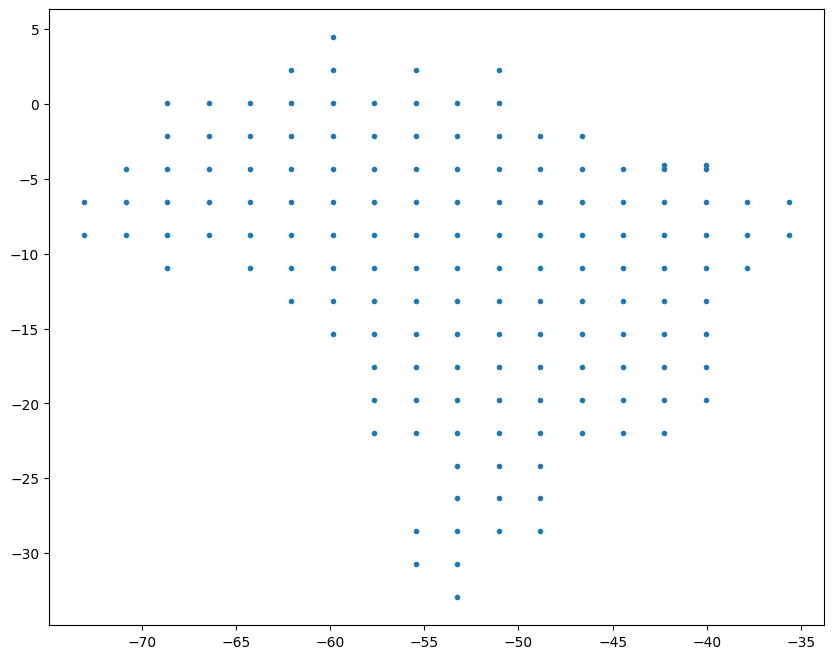

In [22]:
plt.figure(figsize=(10, 8))
plt.scatter(longitudes, latitudes, marker='.')

A base escolhida foi a de coordenadas geográficas com latitude -19.75 e longitude -44.45, correspondente à localidade de Pará de Minas/MG, ponto mais próximo da estação meteorológica de Sete Lagoas/MG (lat. -19.46, lon. -44.25), objeto de estudo nos trabalhos listados a seguir:<br>
- [LUCAS, Patrícia de Oliveira e. *Previsão de Séries Temporais de Evapotranspiração de Referência com Redes Neurais Convolucionais*](https://repositorio.ufmg.br/bitstream/1843/32870/6/Dissertacao_Patricia_Lucas.pdf)
- [Patrícia de Oliveira e Lucas, Marcos Antonio Alves, Petrônio Cândido de Lima e Silva, Frederico Gadelha Guimarães. *Reference evapotranspiration time series forecasting with ensemble of convolutional neural networks*](https://doi.org/10.1016/j.compag.2020.105700)
- [Patrícia de Oliveira e Lucas et al. REFERENCE EVAPOTRANSPIRATION PREDICTION FOR PRECISION AGRICULTURE USING FUZZY TIME SERIES.](https://proceedings.science/sbpo/sbpo-2022/trabalhos/reference-evapotranspiration-prediction-for-precision-agriculture-using-fuzzy-ti?lang=pt-br)

Importando a base de dados escolhida.

In [2]:
df_target = pd.read_csv('datasets/clima/lat-19.75_lon-44.45.csv', parse_dates=True, index_col='Unnamed: 0')
df_target = df_target.round(decimals=1)
df_target.fillna(0, inplace=True)
df_target.head()

Rs   u2  Tmax  Tmin    RH    pr  ETo
2000-01-01  10.5  1.0  23.2  18.9  93.7  22.2  2.2
2000-01-02  11.1  1.4  25.2  19.4  90.1  24.8  2.4
2000-01-03  11.5  1.6  26.4  19.0  86.4  30.2  2.6
2000-01-04  12.3  1.3  27.6  19.0  84.2  34.7  2.8
2000-01-05  21.9  1.0  31.0  19.4  73.8   9.9  4.7

In [41]:
df_target.tail()

Rs   u2  Tmax  Tmin    RH   pr  ETo
2019-12-27  25.5  2.0  31.0  18.3  65.7  0.0  5.8
2019-12-28  22.6  1.6  31.0  18.0  67.5  0.0  5.1
2019-12-29  23.1  1.4  31.4  18.1  70.9  0.0  5.1
2019-12-30  25.1  1.7  31.1  17.2  64.9  0.0  5.6
2019-12-31  26.8  1.9  32.1  16.7  62.6  0.0  6.1

Plotando a série de ETo.

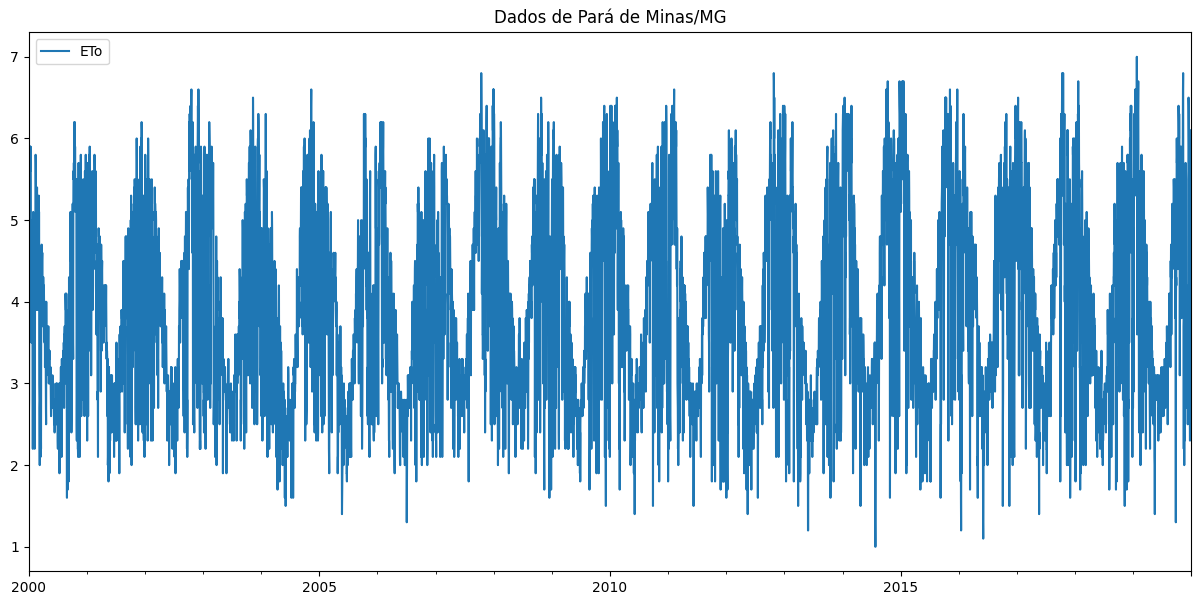

In [3]:
df_target['ETo'].plot(title='Dados de Pará de Minas/MG')
plt.legend(loc='best')
plt.show()

Confirmando a presença de sazonalidade.

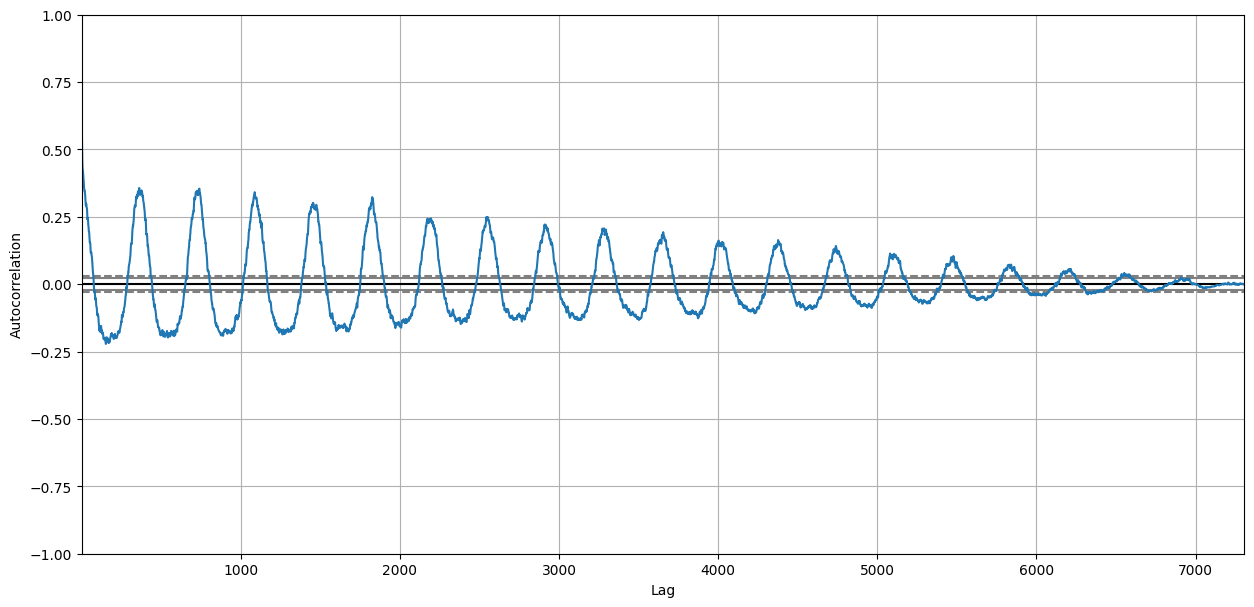

In [43]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_target['ETo'])
plt.show()

Analisando os componentes das série.

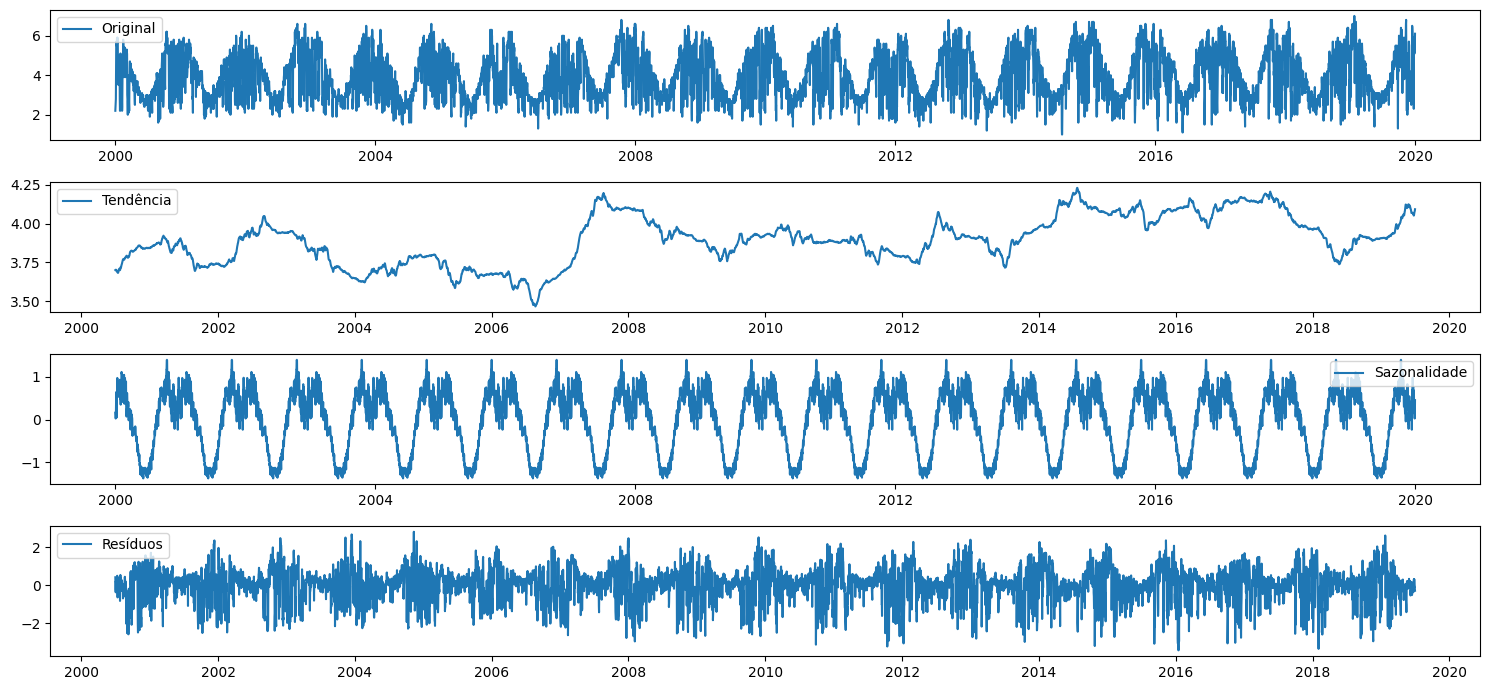

In [45]:
# Análise preliminar dos componentes da série: tendência, sazonalidade e resíduos.

decomposicao = seasonal_decompose(df_target['ETo'], period=365)

tendencia = decomposicao.trend
sazonalidade = decomposicao.seasonal
residuo = decomposicao.resid

plt.subplot(411)
plt.plot(df_target['ETo'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Tendência')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(sazonalidade,label='Sazonalidade')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuo, label='Resíduos')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Confirmando o período de sazonalidade: semestral.

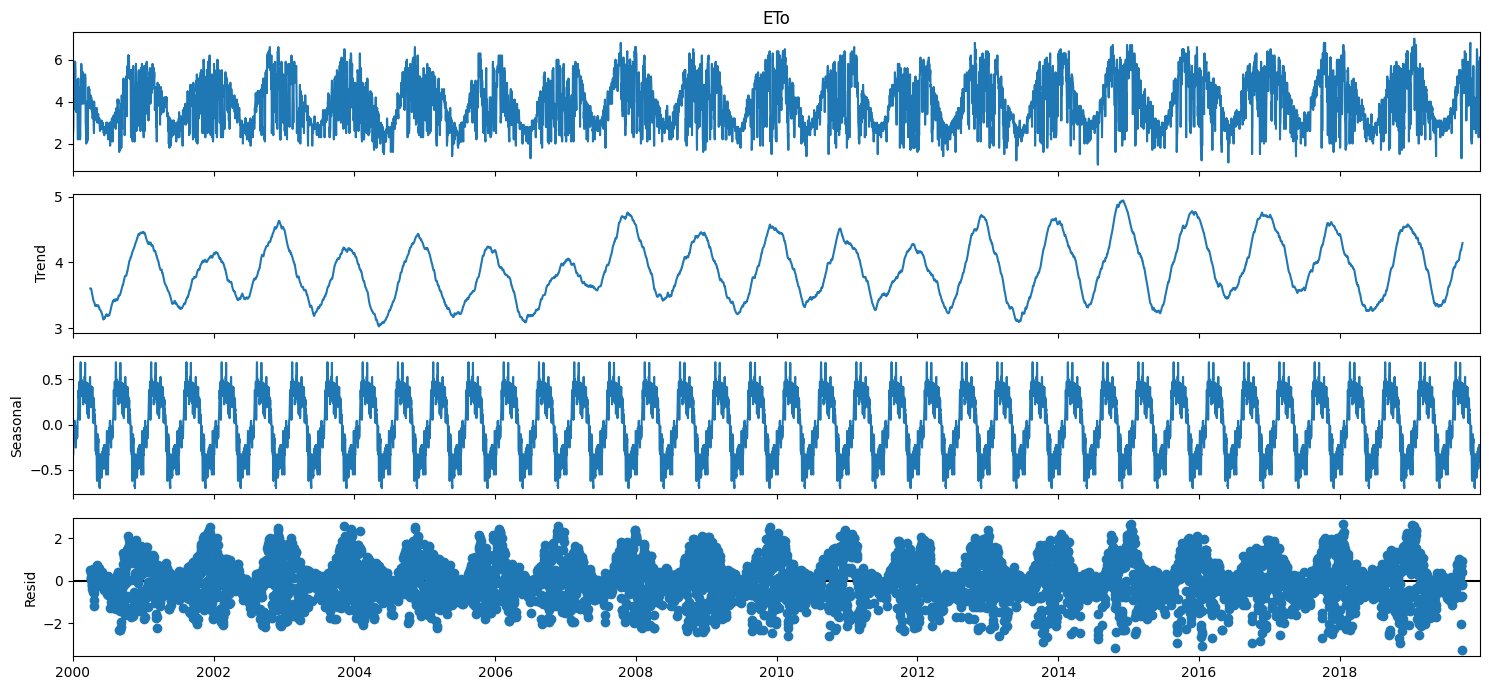

In [46]:
decomposition=seasonal_decompose(df_target['ETo'], model='additive', period=183)
decomposition.plot()
plt.show()

Verificando a estacionariedade da série.

In [47]:
teste_estacionariedade(df_target['ETo'])

valor-p = 2.797460563880368e-15. A série ETo parece ser estacionária.


True

In [48]:
dftest = adfuller(df_target['ETo'], autolag = 'AIC')
print("1. ADF : ", dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -9.144138505074833
2. P-Value :  2.797460563880368e-15
3. Num Of Lags :  19
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 7285
5. Critical Values :
	 1% :  -3.4312479554815933
	 5% :  -2.861936826623019
	 10% :  -2.5669812265733456


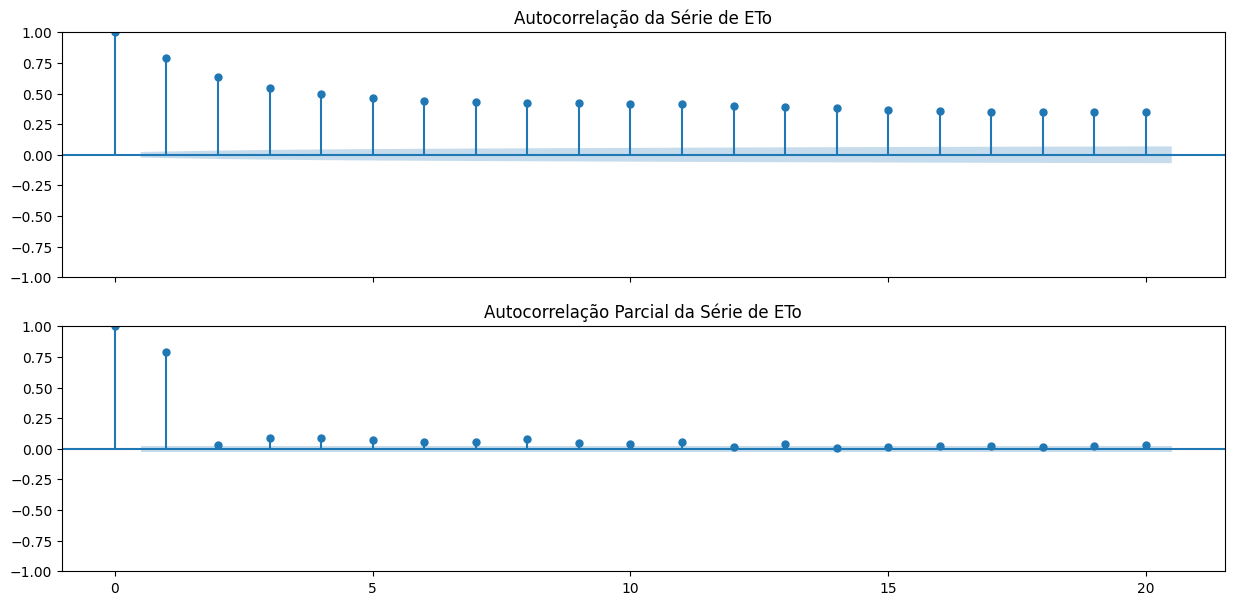

In [49]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

smt.graphics.plot_acf(df_target['ETo'], ax=ax1, lags=20, alpha=0.05, title="Autocorrelação da Série de ETo")
smt.graphics.plot_pacf(df_target['ETo'], ax=ax2, lags=20,  alpha=0.05, title="Autocorrelação Parcial da Série de ETo")
plt.show()

Pelos correlogramas, a série parece representar um processo autogressivo de ordem 1, AR(1). No entanto, vamos testar usar pmdarima.arima.auto_arima para tentar obter os melhores hiperparâmetros para o modelo.

In [3]:
# Rodando o auto_arima para os primeiros 365 dias da série (2000).

stepwise = auto_arima(df_target['ETo'][:365],
                      start_p=0,
                      start_q=0,
                      d=0,
                      max_p=1,
                      max_q=1,
                      start_P=0,
                      start_Q=0,
                      D=0,
                      max_P=1, max_Q=1, max_D=1, max_order=1,
                      m=183,
                      seasonal=True,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True, maxiter=3)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[183] intercept   : AIC=1088.071, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[183] intercept   : AIC=inf, Time=22.88 sec
 ARIMA(0,0,1)(0,0,1)[183] intercept   : AIC=inf, Time=21.64 sec
 ARIMA(0,0,0)(0,0,0)[183]             : AIC=2022.136, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[183] intercept   : AIC=inf, Time=18.71 sec
 ARIMA(0,0,0)(0,0,1)[183] intercept   : AIC=inf, Time=31.81 sec
 ARIMA(0,0,0)(1,0,1)[183] intercept   : AIC=inf, Time=36.61 sec
 ARIMA(1,0,0)(0,0,0)[183] intercept   : AIC=752.189, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[183] intercept   : AIC=751.513, Time=21.12 sec
 ARIMA(1,0,0)(1,0,1)[183] intercept   : AIC=753.552, Time=28.05 sec
 ARIMA(1,0,1)(0,0,1)[183] intercept   : AIC=753.262, Time=25.35 sec
 ARIMA(1,0,0)(0,0,1)[183]             : AIC=792.227, Time=20.93 sec

Best model:  ARIMA(1,0,0)(0,0,1)[183] intercept
Total fit time: 231.891 seconds


In [4]:
# Rodando o auto_arima para o segundo ano da série (2001).

stepwise = auto_arima(df_target['ETo'][365:730],
                      start_p=0,
                      start_q=0,
                      d=0,
                      max_p=1,
                      max_q=1,
                      start_P=0,
                      start_Q=0,
                      D=0,
                      max_P=1, max_Q=1, max_D=1, max_order=1,
                      m=183,
                      seasonal=True,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True, maxiter=3)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[183] intercept   : AIC=1076.032, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[183] intercept   : AIC=inf, Time=26.16 sec
 ARIMA(0,0,1)(0,0,1)[183] intercept   : AIC=894.816, Time=23.54 sec
 ARIMA(0,0,0)(0,0,0)[183]             : AIC=2044.827, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[183] intercept   : AIC=894.833, Time=0.09 sec
 ARIMA(0,0,1)(1,0,1)[183] intercept   : AIC=898.971, Time=28.87 sec
 ARIMA(0,0,1)(1,0,0)[183] intercept   : AIC=1843.685, Time=23.25 sec
 ARIMA(0,0,0)(0,0,1)[183] intercept   : AIC=inf, Time=22.35 sec
 ARIMA(1,0,1)(0,0,1)[183] intercept   : AIC=793.837, Time=32.09 sec
 ARIMA(1,0,1)(0,0,0)[183] intercept   : AIC=791.840, Time=0.05 sec
 ARIMA(1,0,1)(1,0,0)[183] intercept   : AIC=1152.008, Time=28.00 sec
 ARIMA(1,0,1)(1,0,1)[183] intercept   : AIC=795.838, Time=33.11 sec
 ARIMA(1,0,0)(0,0,0)[183] intercept   : AIC=789.956, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[183] intercept   : AIC=791.953, Time=41.40 sec
 ARIMA(1,0,0)(

In [5]:
# Rodando o auto_arima para o segundo ano da série (2004).

stepwise = auto_arima(df_target['ETo'][1460:1825],
                      start_p=0,
                      start_q=0,
                      d=0,
                      max_p=1,
                      max_q=1,
                      start_P=0,
                      start_Q=0,
                      D=0,
                      max_P=1, max_Q=1, max_D=1, max_order=1,
                      m=183,
                      seasonal=True,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True, maxiter=3)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[183] intercept   : AIC=1129.985, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[183] intercept   : AIC=758.524, Time=55.25 sec
 ARIMA(0,0,1)(0,0,1)[183] intercept   : AIC=900.992, Time=48.65 sec
 ARIMA(0,0,0)(0,0,0)[183]             : AIC=2020.728, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[183] intercept   : AIC=756.542, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[183] intercept   : AIC=758.523, Time=26.56 sec
 ARIMA(1,0,0)(1,0,1)[183] intercept   : AIC=760.518, Time=28.04 sec
 ARIMA(1,0,1)(0,0,0)[183] intercept   : AIC=757.391, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[183] intercept   : AIC=903.256, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[183]             : AIC=792.457, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[183] intercept
Total fit time: 158.974 seconds


In [6]:
# Rodando o auto_arima para o segundo ano da série (2006).

stepwise = auto_arima(df_target['ETo'][2190:2555],
                      start_p=0,
                      start_q=0,
                      d=0,
                      max_p=1,
                      max_q=1,
                      start_P=0,
                      start_Q=0,
                      D=0,
                      max_P=1, max_Q=1, max_D=1, max_order=1,
                      m=183,
                      seasonal=True,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True, maxiter=3)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[183] intercept   : AIC=1082.285, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[183] intercept   : AIC=inf, Time=26.11 sec
 ARIMA(0,0,1)(0,0,1)[183] intercept   : AIC=887.915, Time=21.99 sec
 ARIMA(0,0,0)(0,0,0)[183]             : AIC=2010.069, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[183] intercept   : AIC=890.569, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1)[183] intercept   : AIC=891.581, Time=29.70 sec
 ARIMA(0,0,1)(1,0,0)[183] intercept   : AIC=1951.420, Time=21.18 sec
 ARIMA(0,0,0)(0,0,1)[183] intercept   : AIC=inf, Time=19.54 sec
 ARIMA(1,0,1)(0,0,1)[183] intercept   : AIC=757.277, Time=29.23 sec
 ARIMA(1,0,1)(0,0,0)[183] intercept   : AIC=755.240, Time=0.06 sec
 ARIMA(1,0,1)(1,0,0)[183] intercept   : AIC=1065.477, Time=33.99 sec
 ARIMA(1,0,1)(1,0,1)[183] intercept   : AIC=759.287, Time=35.75 sec
 ARIMA(1,0,0)(0,0,0)[183] intercept   : AIC=754.425, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[183] intercept   : AIC=756.387, Time=26.15 sec
 ARIMA(1,0,0)(

In [7]:
# Rodando o auto_arima para o segundo ano da série (2018).

stepwise = auto_arima(df_target['ETo'][6570:6935],
                      start_p=0,
                      start_q=0,
                      d=0,
                      max_p=1,
                      max_q=1,
                      start_P=0,
                      start_Q=0,
                      D=0,
                      max_P=1, max_Q=1, max_D=1, max_order=1,
                      m=183,
                      seasonal=True,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True, maxiter=3)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[183] intercept   : AIC=1140.097, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[183] intercept   : AIC=inf, Time=26.66 sec
 ARIMA(0,0,1)(0,0,1)[183] intercept   : AIC=982.874, Time=23.38 sec
 ARIMA(0,0,0)(0,0,0)[183]             : AIC=2048.352, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[183] intercept   : AIC=982.628, Time=0.04 sec
 ARIMA(0,0,1)(1,0,0)[183] intercept   : AIC=3744.270, Time=21.50 sec
 ARIMA(0,0,1)(1,0,1)[183] intercept   : AIC=985.317, Time=31.96 sec
 ARIMA(1,0,1)(0,0,0)[183] intercept   : AIC=867.874, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[183] intercept   : AIC=1405.738, Time=28.00 sec
 ARIMA(1,0,1)(0,0,1)[183] intercept   : AIC=869.622, Time=26.59 sec
 ARIMA(1,0,1)(1,0,1)[183] intercept   : AIC=871.700, Time=33.25 sec
 ARIMA(1,0,0)(0,0,0)[183] intercept   : AIC=870.634, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[183]             : AIC=897.641, Time=0.03 sec

Best model:  ARIMA(1,0,1)(0,0,0)[183] intercept
Total fit time: 192.134 second

In [8]:
# Rodando o auto_arima para o segundo ano da série (2018).

stepwise = auto_arima(df_target['ETo'][6940:7305],
                      start_p=0,
                      start_q=0,
                      d=0,
                      max_p=1,
                      max_q=1,
                      start_P=0,
                      start_Q=0,
                      D=0,
                      max_P=1, max_Q=1, max_D=1, max_order=1,
                      m=183,
                      seasonal=True,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True, maxiter=3)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[183] intercept   : AIC=1203.577, Time=0.19 sec
 ARIMA(1,0,0)(1,0,0)[183] intercept   : AIC=inf, Time=21.01 sec
 ARIMA(0,0,1)(0,0,1)[183] intercept   : AIC=inf, Time=22.72 sec
 ARIMA(0,0,0)(0,0,0)[183]             : AIC=2099.244, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[183] intercept   : AIC=inf, Time=17.07 sec
 ARIMA(0,0,0)(0,0,1)[183] intercept   : AIC=inf, Time=18.30 sec
 ARIMA(0,0,0)(1,0,1)[183] intercept   : AIC=inf, Time=25.63 sec
 ARIMA(1,0,0)(0,0,0)[183] intercept   : AIC=847.188, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[183] intercept   : AIC=849.187, Time=24.97 sec
 ARIMA(1,0,0)(1,0,1)[183] intercept   : AIC=851.187, Time=32.13 sec
 ARIMA(1,0,1)(0,0,0)[183] intercept   : AIC=839.578, Time=0.05 sec
 ARIMA(1,0,1)(1,0,0)[183] intercept   : AIC=1356.271, Time=38.88 sec
 ARIMA(1,0,1)(0,0,1)[183] intercept   : AIC=841.572, Time=27.10 sec
 ARIMA(1,0,1)(1,0,1)[183] intercept   : AIC=843.610, Time=47.15 sec
 ARIMA(0,0,1)(0,0,0)[183] 

Normalizando os dados.

In [5]:
# Normalize Data

# Save Min-Max for Denorm
min_raw = df_target.min()

max_raw = df_target.max()

# Perform Normalization
norm_df = normalize(df_target)
df = df_target

Implementando um AR(1): 
* $y_t = c + \phi_1*y_{t-1} = \epsilon_{t}$

In [6]:
# Modelo ARIMA.

# model = ARIMA(df_target['ETo'], order=(1,0,0))
model = ARIMA(norm_df['ETo'], order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())

# Separando a base de dados em treinamento e teste, na proporção de 80% para 20%.

# X = df_target['ETo'].values
X = norm_df['ETo'].values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

                               SARIMAX Results                                
Dep. Variable:                    ETo   No. Observations:                 7305
Model:                 ARIMA(1, 0, 0)   Log Likelihood                5157.796
Date:                Mon, 11 Dec 2023   AIC                         -10309.592
Time:                        22:11:59   BIC                         -10288.903
Sample:                    01-01-2000   HQIC                        -10302.478
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4826      0.007     72.618      0.000       0.470       0.496
ar.L1          0.7889      0.008     93.116      0.000       0.772       0.806
sigma2         0.0143      0.000     70.864      0.0

In [8]:
# Aplicando a previsão aos dados, usando rolling forecasting.

history = [x for x in train]
predictions = []

n_prints = 3

for t in range(len(test)):
	model = ARIMA(history, order=(1,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	if t < 3 or t >= (len(test) - 3):
		print('previsão=%f, osbervado=%f' % (yhat, obs))		

previsão=0.680182, osbervado=0.716667
previsão=0.667001, osbervado=0.433333
previsão=0.442556, osbervado=0.316667
previsão=0.640897, osbervado=0.766667
previsão=0.706656, osbervado=0.850000


Test MAE: 0.091
Test RMSE: 0.126
Test MAPE: 0.259


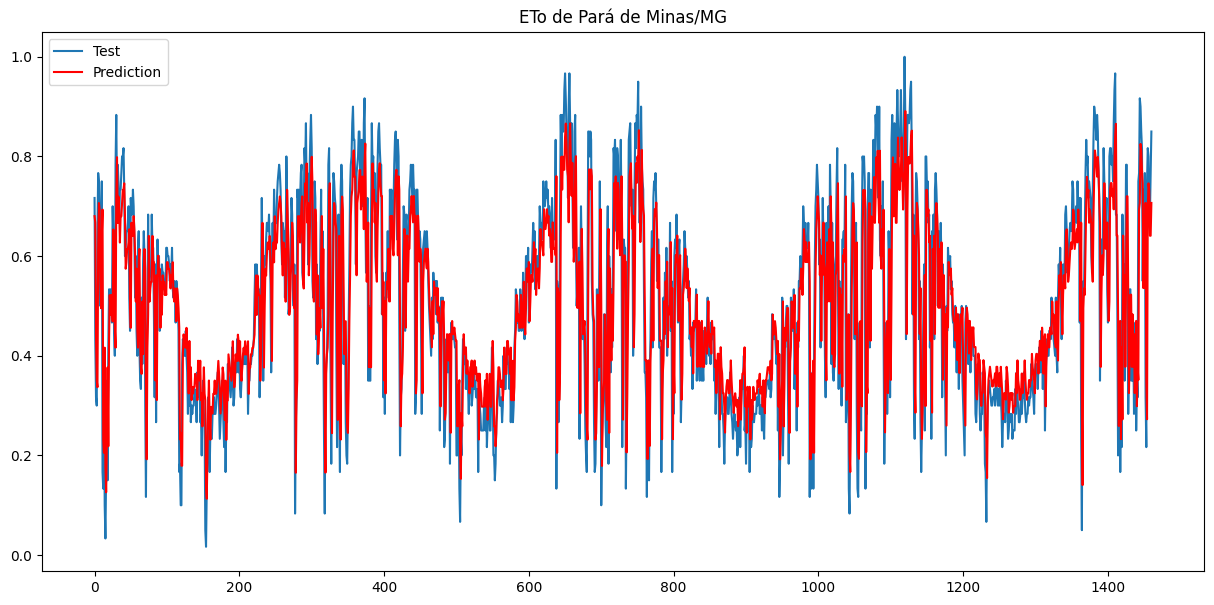

In [9]:
# Medindo o desempenho do modelo a partir das métricas: MAE, RMSE e MAPE

mae_ar = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae_ar)

rmse_ar = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_ar)

mape_ar = mean_absolute_percentage_error(test, predictions)
print('Test MAPE: %.3f' % mape_ar)

plt.title("ETo de Pará de Minas/MG")
plt.plot(test, label='Test')
plt.plot(predictions, color='red', label='Prediction')
plt.legend(loc='best')
plt.show()

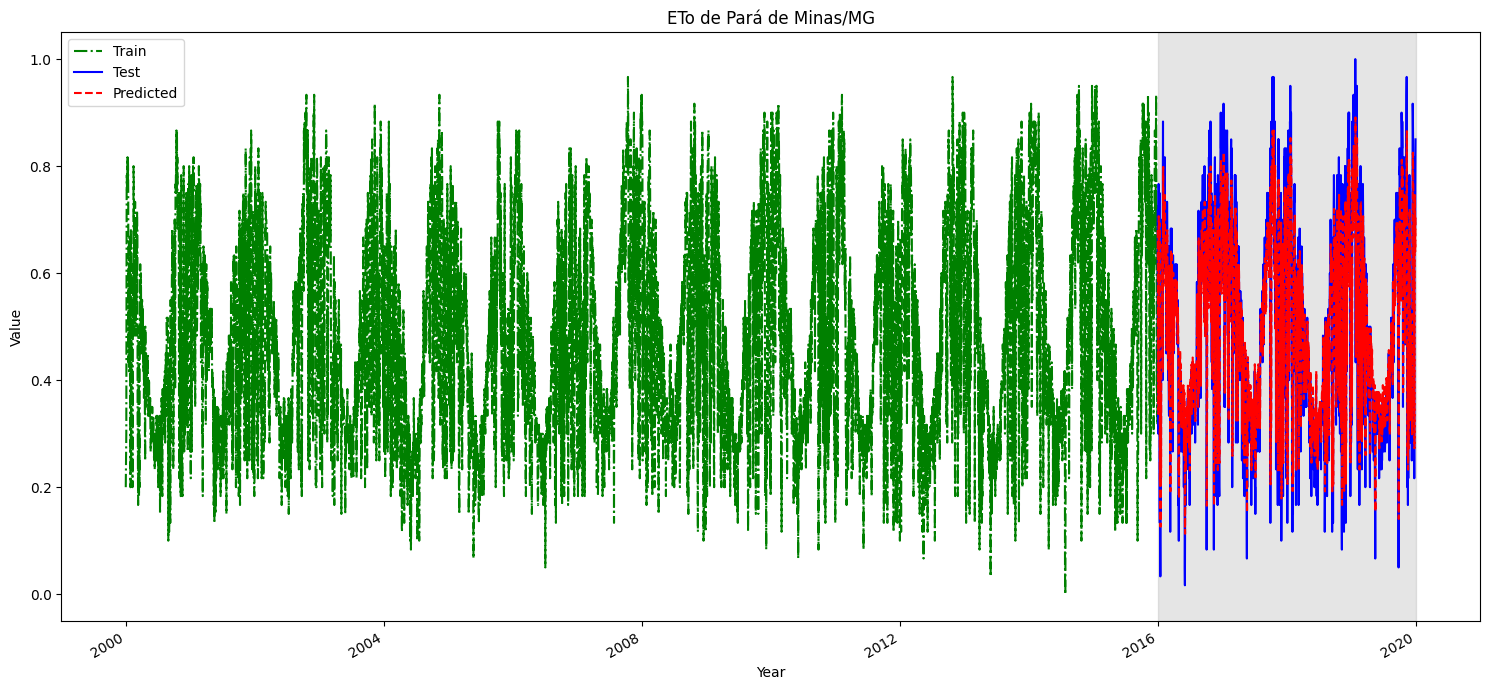

In [10]:
# Ilustrando graficamente o desempenho do modelo ARIMA.

fig, ax = plt.subplots()

ax.plot(df_target['ETo'].index[0:size], train, 'g-.', label='Train')
ax.plot(df_target['ETo'].index[size:len(X)], test, 'b-', label='Test')
ax.plot(df_target['ETo'].index[size:len(X)], predictions, 'r--', label='Predicted')

ax.legend(loc='best')

ax.set_xlabel('Year')
ax.set_ylabel('Value')

# ax.axvline(df_target['ETo'].index[size], color='#808080', linestyle='-', alpha=0.2)
# ax.axvline(df_target['ETo'].index[len(X) - 1], color='#808080', linestyle='-', alpha=0.2)
ax.axvspan(df_target['ETo'].index[size], df_target['ETo'].index[len(X) - 1], color='#808080', alpha=0.2) # zona cinza

plt.title("ETo de Pará de Minas/MG")

fig.autofmt_xdate()
plt.tight_layout()

____________________

### Aqui começam as previsões multivariadas.

In [11]:
df_target.head()

Rs   u2  Tmax  Tmin    RH    pr  ETo
2000-01-01  10.5  1.0  23.2  18.9  93.7  22.2  2.2
2000-01-02  11.1  1.4  25.2  19.4  90.1  24.8  2.4
2000-01-03  11.5  1.6  26.4  19.0  86.4  30.2  2.6
2000-01-04  12.3  1.3  27.6  19.0  84.2  34.7  2.8
2000-01-05  21.9  1.0  31.0  19.4  73.8   9.9  4.7

Variáveis *exógenas* (preditores, variáveis de entrada):
- Rs - Solar radiation
- u2 - Wind speed
- Tmax - Maximum temperature
- Tmin - Minimum temperature
- RH - Relative humidity
- pr - Precipitation

Variável *endógena* (variável alvo, variável de interesse, variável de saída):
- ETo - Reference Evapotranspiration

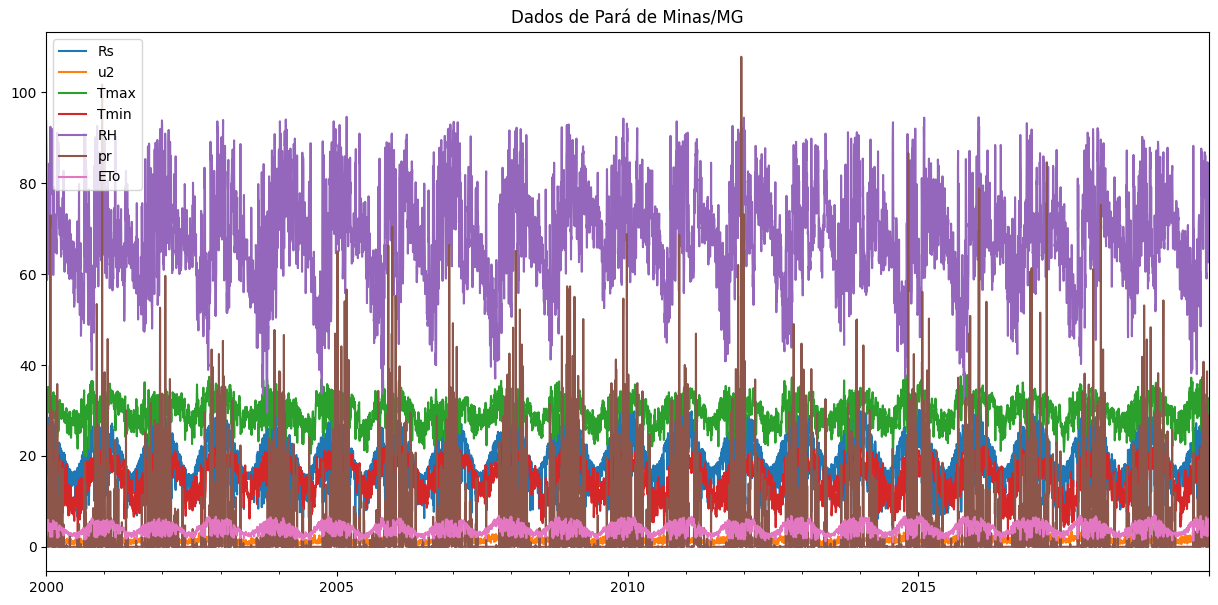

In [56]:
df_target.plot(title='Dados de Pará de Minas/MG')
plt.legend(loc='best')
plt.show()

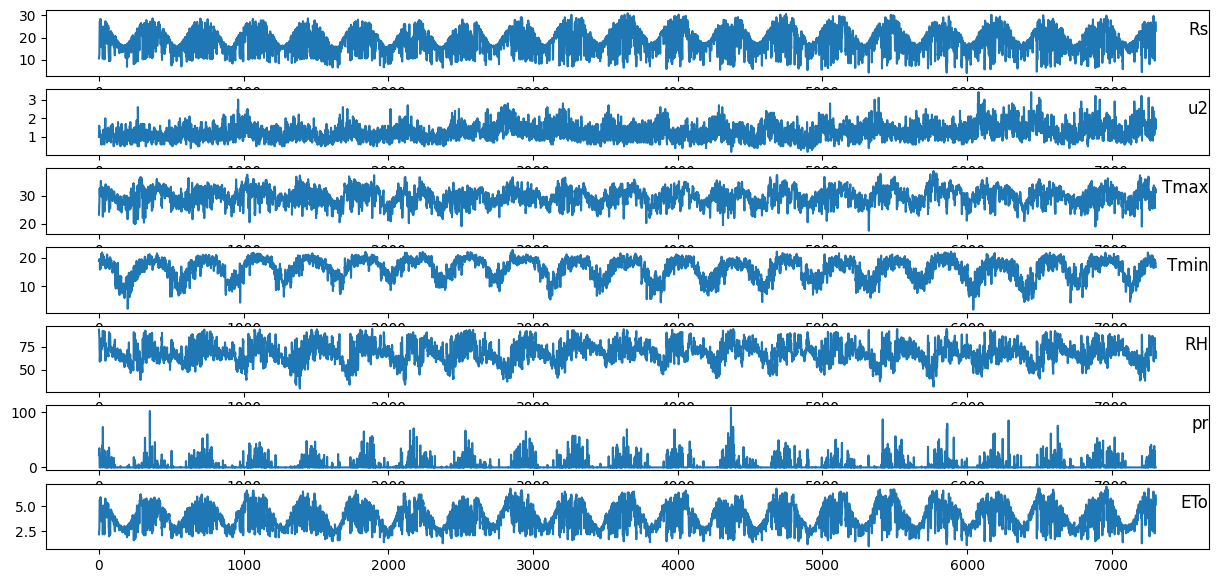

In [12]:
values = df_target.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df_target.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

Separando os dados da variável alvo, das variáveis *exógenas*.

In [16]:
target = df_target[['ETo']]
target.name = 'ETo'
target.head()

ETo
2000-01-01  2.2
2000-01-02  2.4
2000-01-03  2.6
2000-01-04  2.8
2000-01-05  4.7

In [17]:
exog = df_target[['Rs', 'u2', 'Tmax', 'Tmin', 'RH', 'pr']]
exog.name = 'Exogenous Variables'
exog.head()

Rs   u2  Tmax  Tmin    RH    pr
2000-01-01  10.5  1.0  23.2  18.9  93.7  22.2
2000-01-02  11.1  1.4  25.2  19.4  90.1  24.8
2000-01-03  11.5  1.6  26.4  19.0  86.4  30.2
2000-01-04  12.3  1.3  27.6  19.0  84.2  34.7
2000-01-05  21.9  1.0  31.0  19.4  73.8   9.9

Testando a estacionariedade da série alvo.

In [22]:
teste_estacionariedade(target)

valor-p = 2.7974605638801155e-15. A série ETo parece ser estacionária.


True

In [23]:
from statsmodels.tsa.api import VAR

In [24]:
def normalize(df):
    mindf = df.min()
    maxdf = df.max()
    return (df-mindf)/(maxdf-mindf)

def denormalize(norm, _min, _max):
    return [(n * (_max-_min)) + _min for n in norm]

In [25]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1)#, join_axes=[df.index])
    return df

In [26]:
# Normalize Data

# Save Min-Max for Denorm
min_raw = df_target.min()

max_raw = df_target.max()

# Perform Normalization
norm_df = normalize(df_target)
df = df_target

In [27]:
norm_df.head()

Rs       u2      Tmax      Tmin        RH        pr   
2000-01-01  0.243542  0.25000  0.268868  0.816038  0.986175  0.205937  \
2000-01-02  0.265683  0.37500  0.363208  0.839623  0.930876  0.230056   
2000-01-03  0.280443  0.43750  0.419811  0.820755  0.874040  0.280148   
2000-01-04  0.309963  0.34375  0.476415  0.820755  0.840246  0.321892   
2000-01-05  0.664207  0.25000  0.636792  0.839623  0.680492  0.091837   

                 ETo  
2000-01-01  0.200000  
2000-01-02  0.233333  
2000-01-03  0.266667  
2000-01-04  0.300000  
2000-01-05  0.616667

Implementando um modelo VAR(1), com 7 variáveis (Rs, u2, Tmax, Tmin, RH, pr, ETo):

* $y_{1,t} = c_1 + \phi_{11, 1}*y_{1,t-1} + \phi_{12,1}*y_{2,t-1} + \phi_{13,1}*y_{3,t-1} + \phi_{14,1}*y_{4,t-1} + \phi_{15,1}*y_{5,t-1} + \phi_{16,1}*y_{6,t-1} + \phi_{17,1}*y_{7,t-1} + \epsilon_{1,t}$

* $y_{2,t} = c_2 + \phi_{21, 1}*y_{1,t-1} + \phi_{22,1}*y_{2,t-1} + \phi_{23,1}*y_{3,t-1} + \phi_{24,1}*y_{4,t-1} + \phi_{25,1}*y_{5,t-1} + \phi_{26,1}*y_{6,t-1} + \phi_{27,1}*y_{7,t-1} + \epsilon_{2,t}$

* $y_{3,t} = c_2 + \phi_{31, 1}*y_{1,t-1} + \phi_{32,1}*y_{2,t-1} + \phi_{33,1}*y_{3,t-1} + \phi_{34,1}*y_{4,t-1} + \phi_{35,1}*y_{5,t-1} + \phi_{36,1}*y_{6,t-1} + \phi_{37,1}*y_{7,t-1} + \epsilon_{3,t}$

...

* $y_{7,t} = c_2 + \phi_{71, 1}*y_{1,t-1} + \phi_{72,1}*y_{2,t-1} + \phi_{73,1}*y_{3,t-1} + \phi_{74,1}*y_{4,t-1} + \phi_{75,1}*y_{5,t-1} + \phi_{76,1}*y_{6,t-1} + \phi_{77,1}*y_{7,t-1} + \epsilon_{7,t}$

In [28]:
# Separando a base de dados em treinamento e teste, na proporção de 80% para 20%.

# X = df_target['ETo'].values
size = int(len(norm_df) * 0.80)
train, test = norm_df[0:size], norm_df[size:len(norm_df)]

# Modelo VAR.

order = 3
model = VAR(train.values)
model_fit = model.fit(maxlags=order)
lag_order = model_fit.k_ar

print(f'lag_order = {lag_order}\n')
print(model_fit.summary())

lag_order = 3

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 11, Dec, 2023
Time:                     22:30:55
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -38.8687
Nobs:                     5841.00    HQIC:                  -38.9834
Log likelihood:           56167.7    FPE:                1.10442e-17
AIC:                     -39.0446    Det(Omega_mle):     1.07574e-17
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.337793         0.029471           11.462           0.000
L1.y1         0.153082         0.067637            2.263           0.024
L1.y2        -0.140028         0.030479           -4.594           0.000
L1.y3  

*Obs.:* A série de radiação solar (y1) é a que apresenta maior impacto na ETo (y7), seguida pela série de temperatura máxima do ar (y3).

In [29]:
fc = model_fit.forecast(y=test.values, steps=3) # desnormalizar!!! prevendo 3 passos à frente para todas as variáveis.
# print(f'{fc}')
dfc = denormalize(fc, min_raw, max_raw)
# for i in range(len(dfc)):
#     print(f'{dfc[i][6]}')

In [30]:
# Aplicando a previsão aos dados, usando rolling forecasting.

order = 1

history = [x for x in train]
predictions = []

n_prints = 3
max_prints = len(test) - 3

for t in range(len(test)):
	model = VAR(train.values)
	model_fit = model.fit(maxlags=order)
	fc = model_fit.forecast(y=test[:t+1].values, steps=1)
	output = fc[0][6]
	yhat = output
	predictions.append(yhat)
	obs = test['ETo'].iloc[t]
	history.append(obs)
	if t < 3 or t >= (len(test) - 3):
		print('previsão=%f, osbervado=%f' % (yhat, obs))

previsão=0.672375, osbervado=0.716667
previsão=0.437767, osbervado=0.433333
previsão=0.349767, osbervado=0.316667
previsão=0.372427, osbervado=0.300000
previsão=0.611640, osbervado=0.650000
previsão=0.717783, osbervado=0.766667
previsão=0.694854, osbervado=0.750000
previsão=0.552617, osbervado=0.566667
previsão=0.509074, osbervado=0.500000
previsão=0.653821, osbervado=0.683333
previsão=0.711570, osbervado=0.750000
previsão=0.226733, osbervado=0.166667
previsão=0.220343, osbervado=0.133333
previsão=0.431251, osbervado=0.400000
previsão=0.176649, osbervado=0.100000
previsão=0.189393, osbervado=0.033333
previsão=0.327683, osbervado=0.166667
previsão=0.395256, osbervado=0.350000
previsão=0.260860, osbervado=0.150000
previsão=0.507585, osbervado=0.416667
previsão=0.511588, osbervado=0.533333
previsão=0.488959, osbervado=0.483333
previsão=0.533613, osbervado=0.533333
previsão=0.491616, osbervado=0.500000
previsão=0.478283, osbervado=0.466667
previsão=0.671394, osbervado=0.700000
previsão=0.5

In [31]:
# Medindo o desempenho do modelo a partir das métricas: MAE, RMSE e MAPE

mae_var_int = mean_absolute_error(test['ETo'], predictions)
print('Test MAE: %.3f' % mae_var_int)

rmse_var_int = sqrt(mean_squared_error(test['ETo'], predictions))
print('Test RMSE: %.3f' % rmse_var_int)

mape_var_int = mean_absolute_percentage_error(test['ETo'], predictions)
print('Test MAPE: %.3f' % mape_var_int)

Test MAE: 0.042
Test RMSE: 0.052
Test MAPE: 0.124


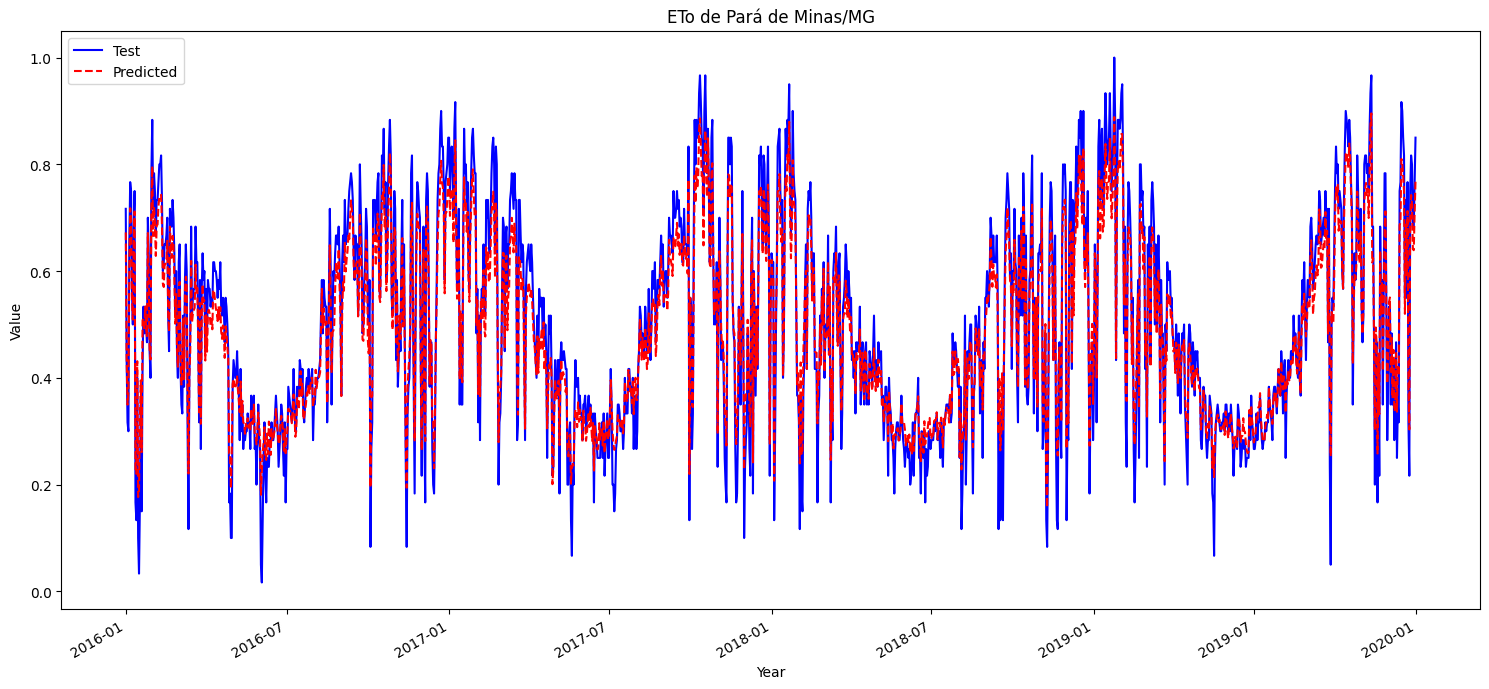

In [34]:
fig, ax = plt.subplots()

ax.plot(df_target['ETo'].index[size:len(df_target)], test['ETo'], 'b-', label='Test')
ax.plot(df_target['ETo'].index[size:len(df_target)], predictions, 'r--', label='Predicted')

ax.legend(loc='best')

ax.set_xlabel('Year')
ax.set_ylabel('Value')

# ax.axvline(df_target['ETo'].index[size], color='#808080', linestyle='-', alpha=0.2)
# ax.axvline(df_target['ETo'].index[len(X) - 1], color='#808080', linestyle='-', alpha=0.2)
# ax.axvspan(df_target['ETo'].index[size], df_target['ETo'].index[len(df_target) - 1], color='#808080', alpha=0.2) # zona cinza

plt.title("ETo de Pará de Minas/MG")

fig.autofmt_xdate()
plt.tight_layout()

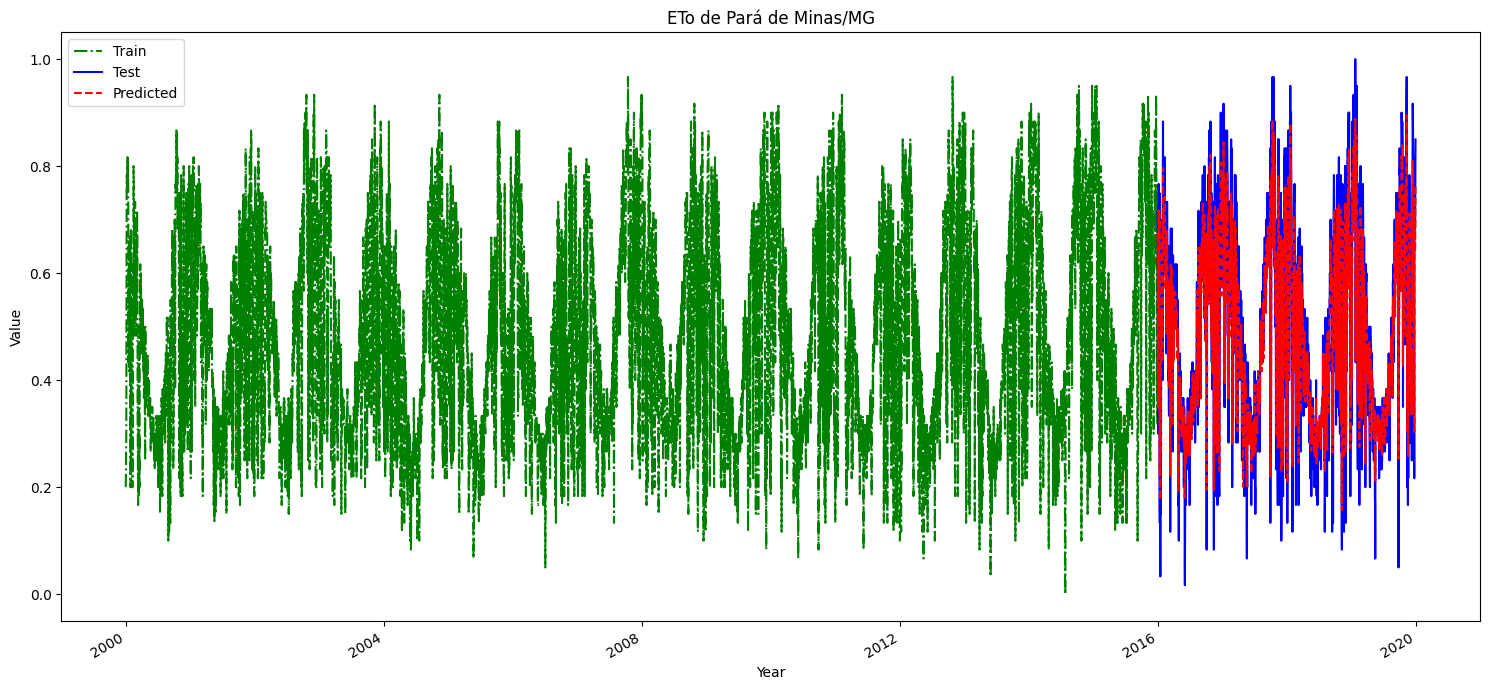

In [35]:
# Ilustrando graficamente o desempenho do modelo ARIMA.

fig, ax = plt.subplots()

ax.plot(df_target['ETo'].index[0:size], train['ETo'], 'g-.', label='Train')
ax.plot(df_target['ETo'].index[size:len(df_target)], test['ETo'], 'b-', label='Test')
ax.plot(df_target['ETo'].index[size:len(df_target)], predictions, 'r--', label='Predicted')

ax.legend(loc='best')

ax.set_xlabel('Year')
ax.set_ylabel('Value')

# ax.axvline(df_target['ETo'].index[size], color='#808080', linestyle='-', alpha=0.2)
# ax.axvline(df_target['ETo'].index[len(X) - 1], color='#808080', linestyle='-', alpha=0.2)
# ax.axvspan(df_target['ETo'].index[size], df_target['ETo'].index[len(X) - 1], color='#808080', alpha=0.2) # zona cinza

plt.title("ETo de Pará de Minas/MG")

fig.autofmt_xdate()
plt.tight_layout()

____________________

### Aqui a ideia é usar a ETo de outras bases para a previsão multivariada.

In [7]:
origin = "datasets/clima/mg/"
geolocator = Nominatim(user_agent='geoapiFSAF')

In [8]:
file_names = []

for path, subdirectory, files in os.walk(origin):
    for name in files:
        file_names.append(name.split(sep='.csv')[0])

len(file_names)

12

In [11]:
latitudes = []
longitudes = []

for fn in file_names:
    lat, lon = return_coordinates(fn,latitudes, longitudes)
    latitudes.append(lat)
    longitudes.append(lon)

-15.35, -42.25
-15.35, -44.45
-15.35, -46.65
-17.55, -42.25
-17.55, -44.45
-17.55, -46.65
-19.75, -42.25
-19.75, -44.45
-19.75, -46.65
-19.75, -48.85
-21.95, -44.45
-21.95, -46.65


In [12]:
all_muni = geobr.read_municipality(code_muni="MG", year=2022)

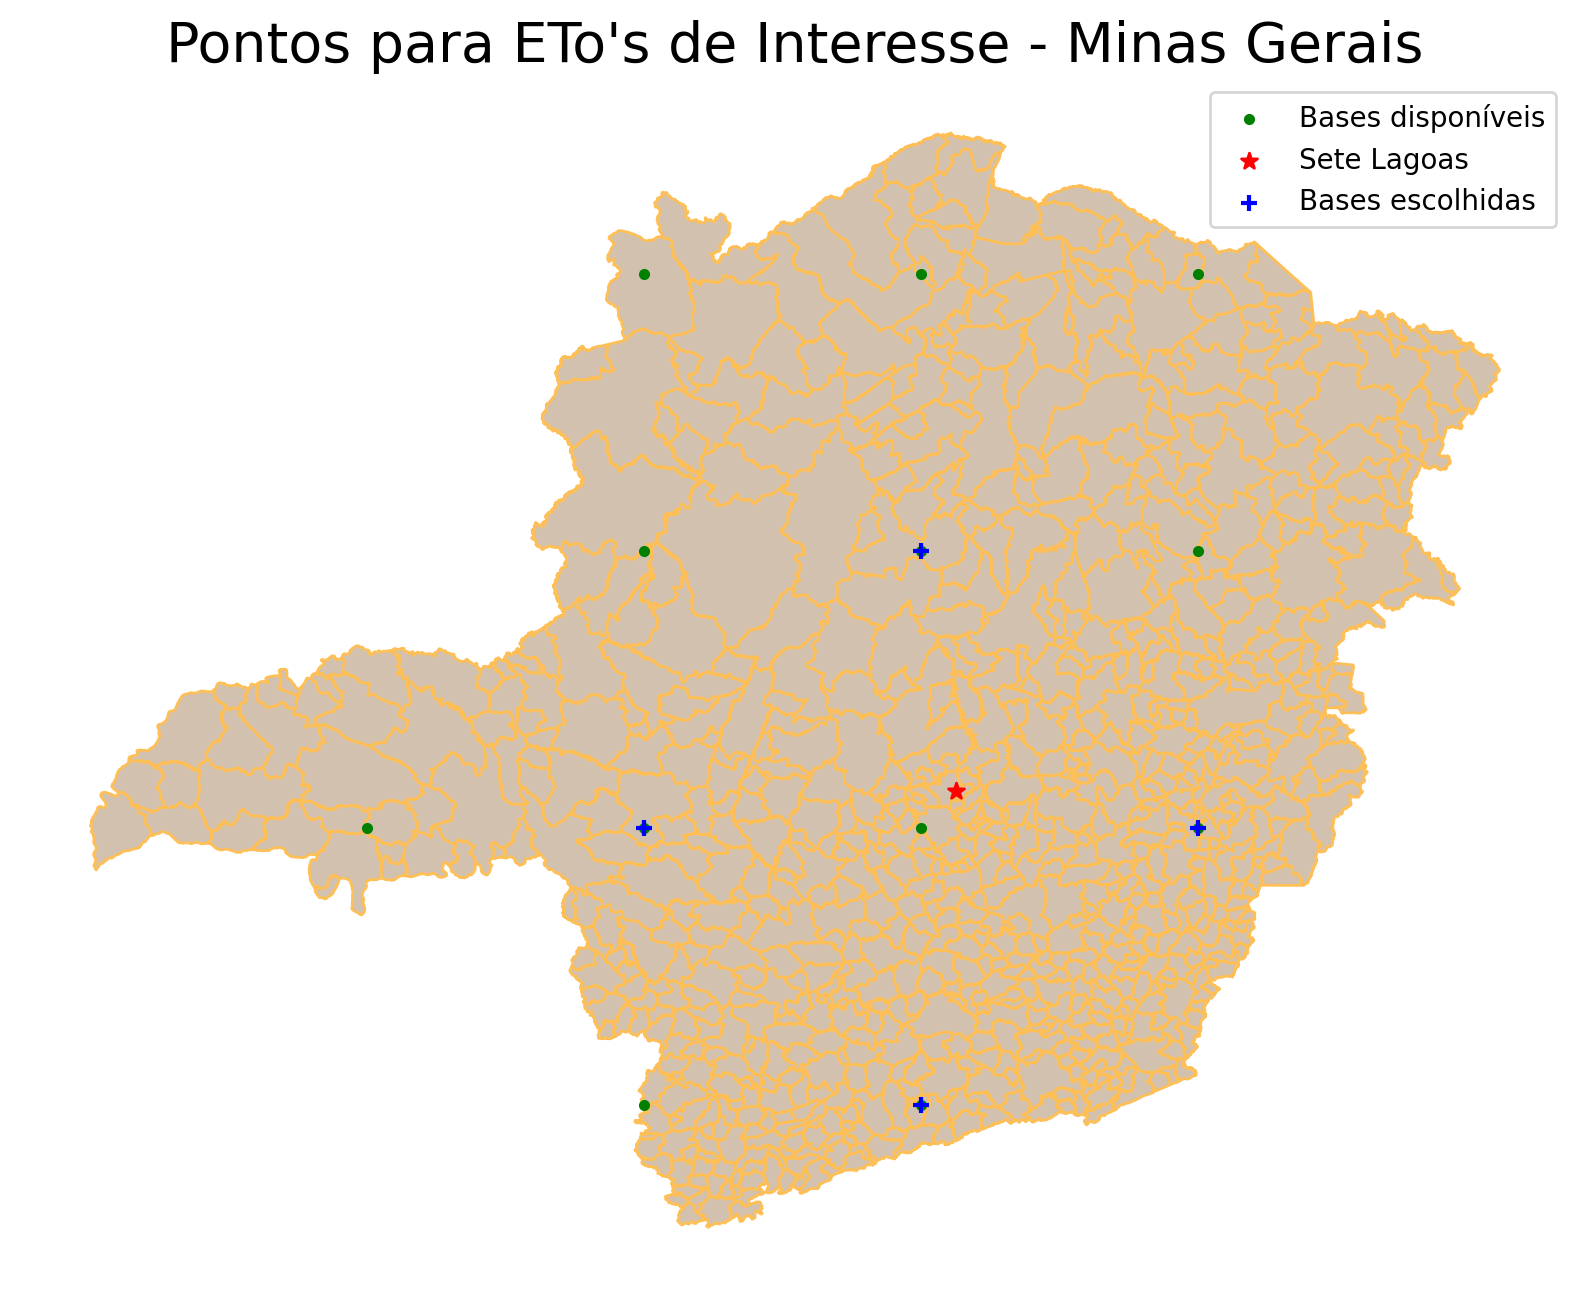

In [17]:
# plot
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)

all_muni.plot(facecolor="#d2c1af", edgecolor="#FEBF57", ax=ax)
plt.scatter(longitudes, latitudes, marker='.', color='green', label='Bases disponíveis')
plt.scatter(-44.17, -19.46, marker='*', color='red', label='Sete Lagoas')
plt.scatter(-44.45, -17.55, marker='+', color='blue', label='Bases escolhidas')
plt.scatter(-42.25, -19.75, marker='+', color='blue')
plt.scatter(-44.45, -21.95, marker='+', color='blue')
plt.scatter(-46.65, -19.75, marker='+', color='blue')
ax.set_title("Pontos para ETo's de Interesse - Minas Gerais", fontsize=20)
ax.axis("off")
plt.legend(loc='best')

plt.show()

In [36]:
df1 = pd.read_csv('datasets/clima/lat-17.55_lon-44.45.csv', parse_dates=True, index_col='Unnamed: 0')
df1.head()

Rs   u2  Tmax  Tmin    RH    pr  ETo
2000-01-01  10.4  1.8  22.2  18.6  93.3  30.2  2.1
2000-01-02  10.7  1.4  22.5  18.3  91.8  49.0  2.2
2000-01-03  14.4  2.3  26.0  17.9  86.4  26.5  3.1
2000-01-04  13.4  1.2  25.7  18.8  85.7  16.7  2.9
2000-01-05  24.1  1.0  29.2  18.2  76.7   2.1  4.9

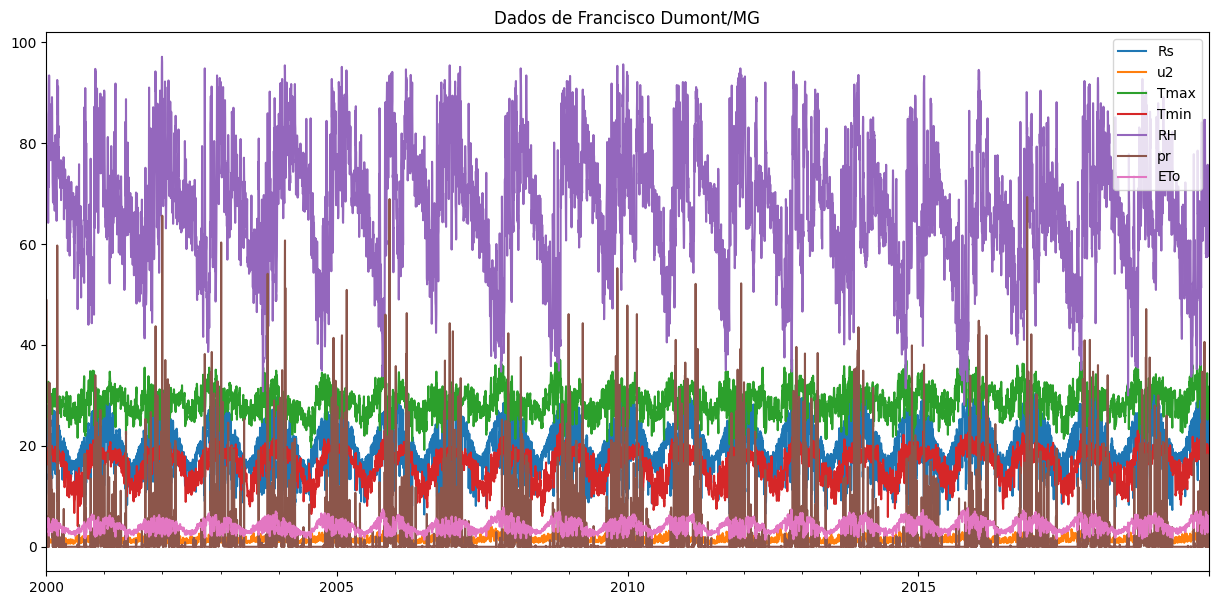

In [37]:
df1.plot(title='Dados de Francisco Dumont/MG')
plt.legend(loc='best')
plt.show()

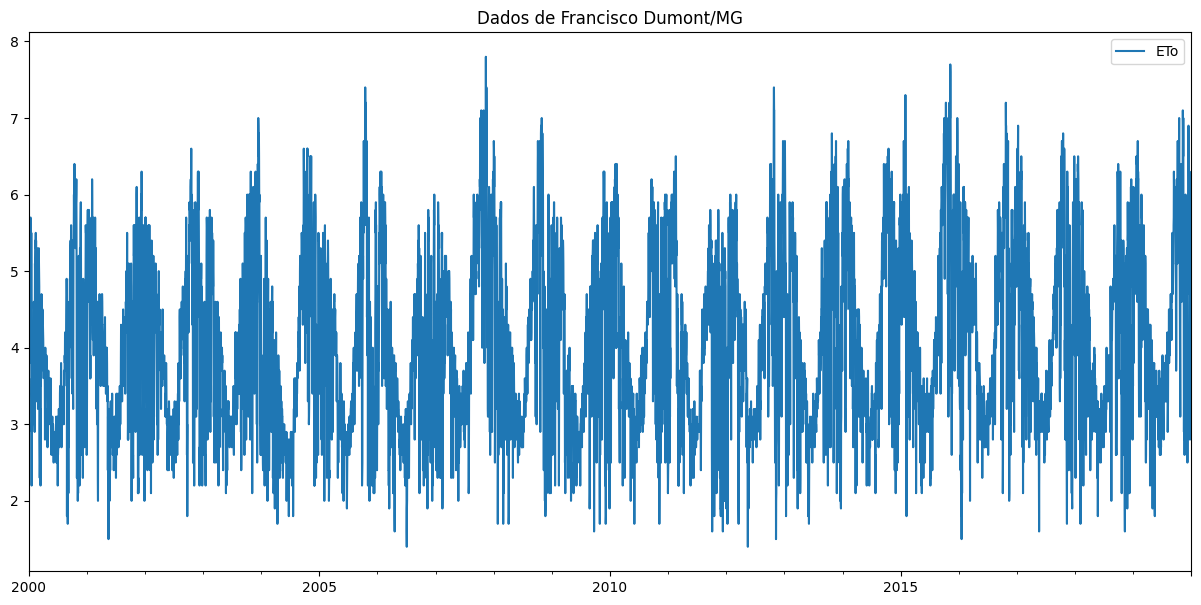

In [74]:
df1['ETo'].plot(title='Dados de Francisco Dumont/MG')
plt.legend(loc='best')
plt.show()

In [38]:
df2 = pd.read_csv('datasets/clima/lat-19.75_lon-42.25.csv', parse_dates=True, index_col='Unnamed: 0')
df2.head()

Rs   u2  Tmax  Tmin    RH    pr  ETo
2000-01-01  10.5  1.4  25.4  19.2  91.0  12.1  2.3
2000-01-02  12.2  1.9  26.9  18.9  89.2  16.0  2.7
2000-01-03  17.0  1.2  28.5  18.6  81.8  16.9  3.6
2000-01-04  13.5  1.4  28.3  19.4  84.2   0.0  3.1
2000-01-05  24.2  1.0  30.1  19.6  80.2   0.0  4.9

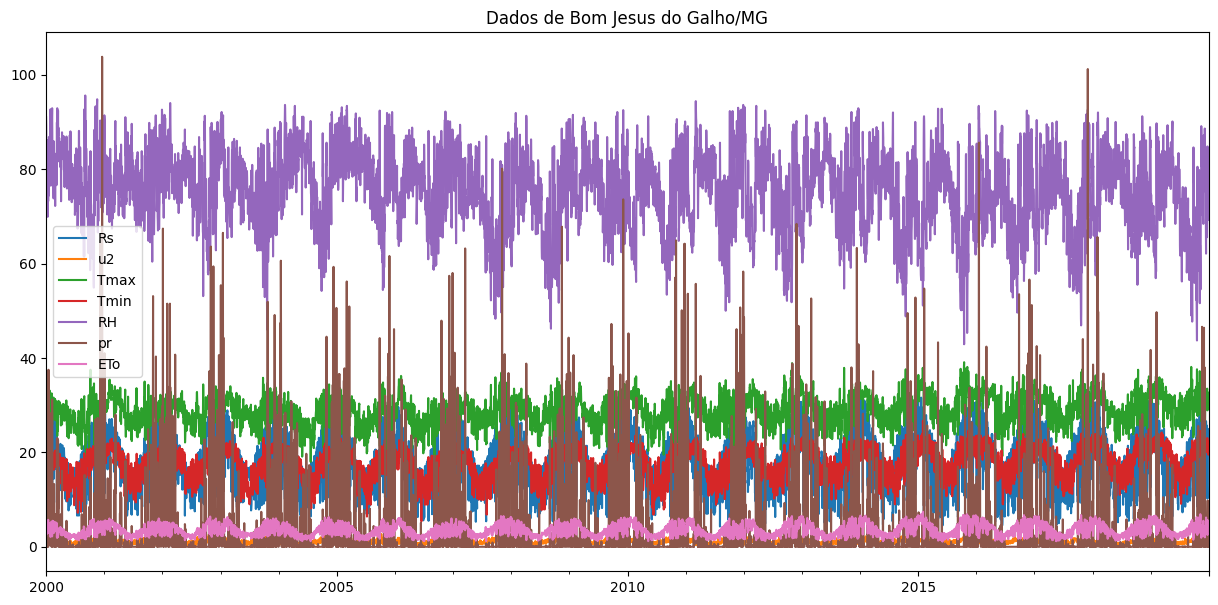

In [76]:
df2.plot(title='Dados de Bom Jesus do Galho/MG')
plt.legend(loc='best')
plt.show()

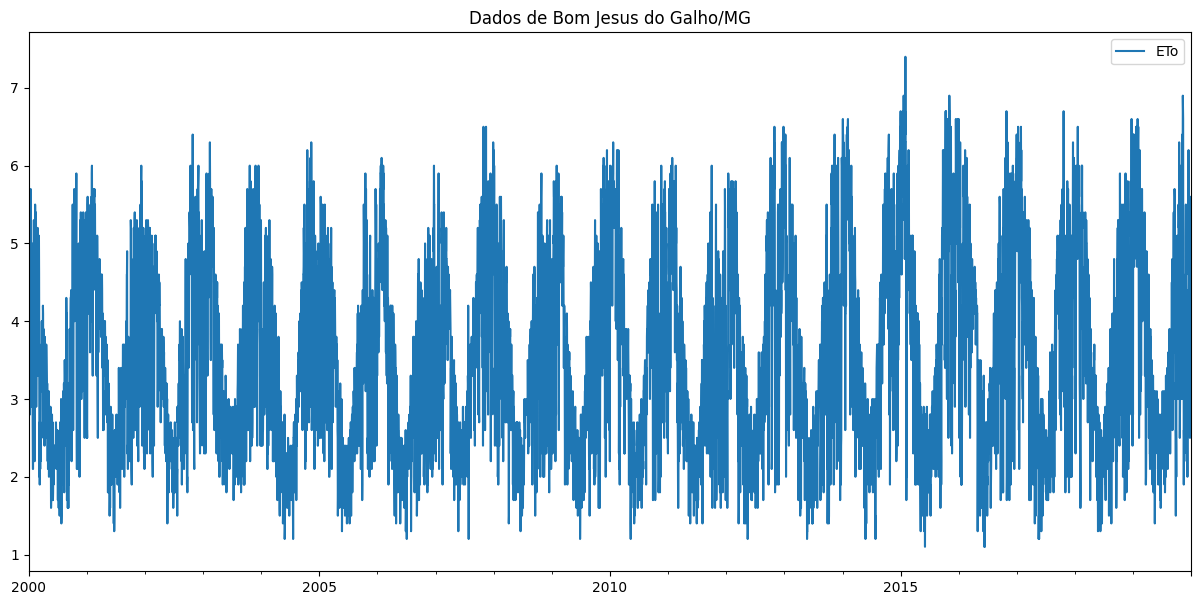

In [77]:
df2['ETo'].plot(title='Dados de Bom Jesus do Galho/MG')
plt.legend(loc='best')
plt.show()

In [39]:
df3 = pd.read_csv('datasets/clima/lat-21.95_lon-44.45.csv', parse_dates=True, index_col='Unnamed: 0')
df3.head()

Rs   u2  Tmax  Tmin    RH    pr  ETo
2000-01-01  10.6  1.3  22.3  16.8  92.2  32.0  2.2
2000-01-02  10.6  1.9  20.7  15.9  93.9  65.6  2.0
2000-01-03  10.8  1.3  20.0  15.1  94.6  72.8  2.1
2000-01-04  11.5  0.9  23.4  15.9  90.2  49.4  2.4
2000-01-05  19.4  1.0  27.8  15.9  80.7  22.7  3.9

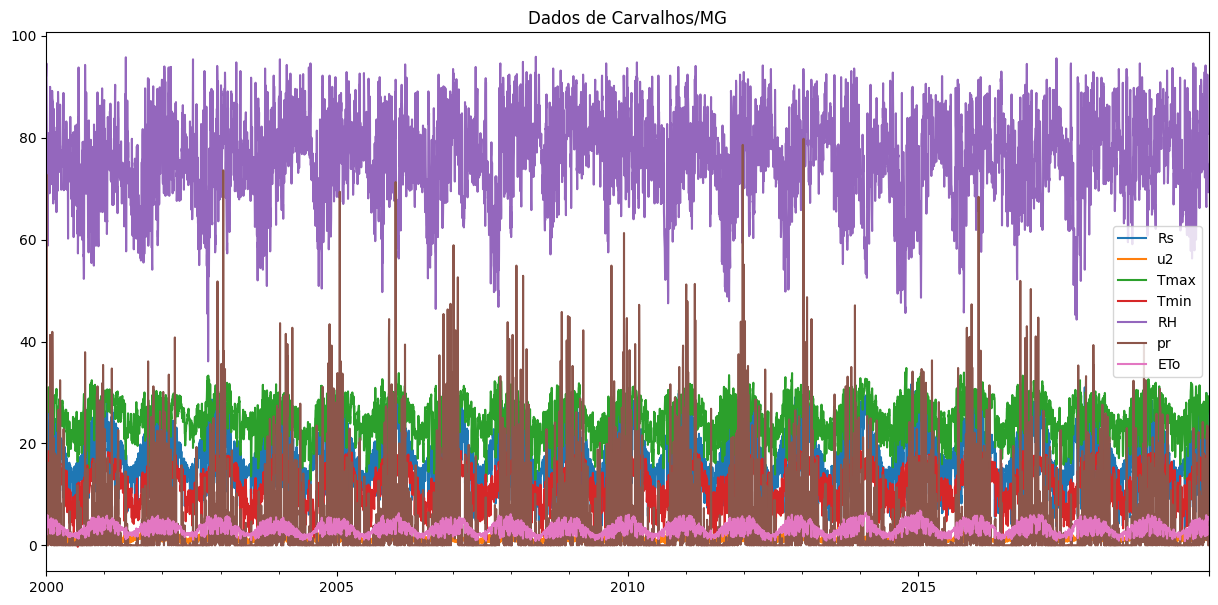

In [79]:
df3.plot(title='Dados de Carvalhos/MG')
plt.legend(loc='best')
plt.show()

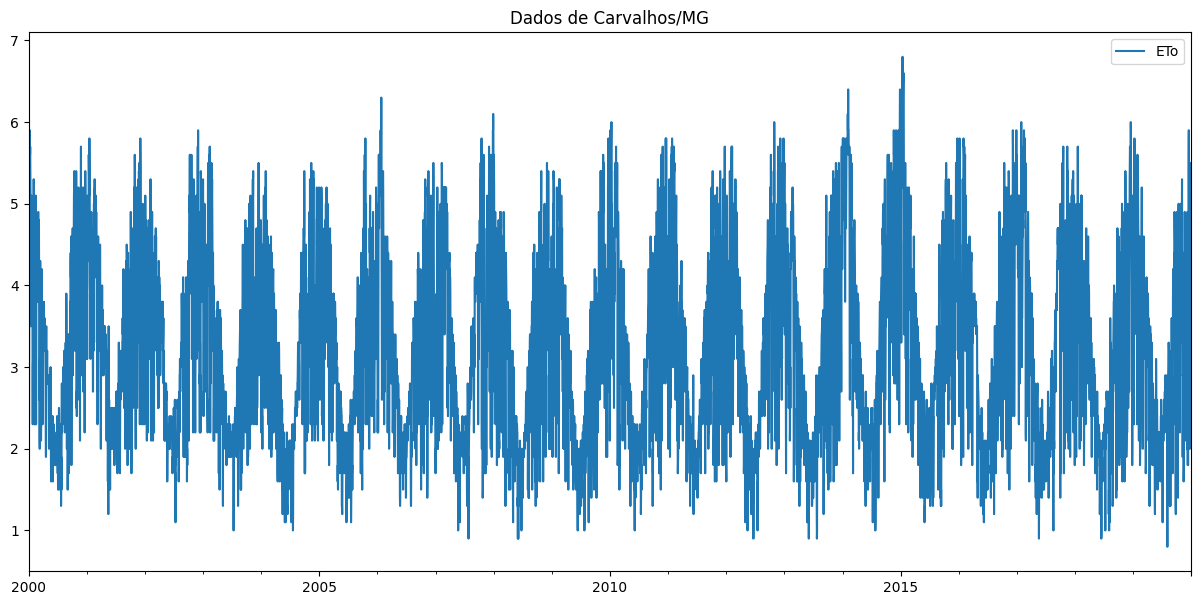

In [80]:
df3['ETo'].plot(title='Dados de Carvalhos/MG')
plt.legend(loc='best')
plt.show()

In [40]:
df4 = pd.read_csv('datasets/clima/lat-19.75_lon-46.65.csv', parse_dates=True, index_col='Unnamed: 0')
df4.head()

Rs   u2  Tmax  Tmin    RH    pr  ETo
2000-01-01  11.0  1.3  24.6  18.1  93.2  30.3  2.3
2000-01-02  10.6  2.0  24.9  18.5  90.8  29.6  2.3
2000-01-03  10.5  1.8  21.6  17.6  94.9  35.6  2.1
2000-01-04  10.7  1.6  24.2  17.6  93.9  38.1  2.2
2000-01-05  11.5  1.2  25.4  18.1  90.5  10.4  2.5

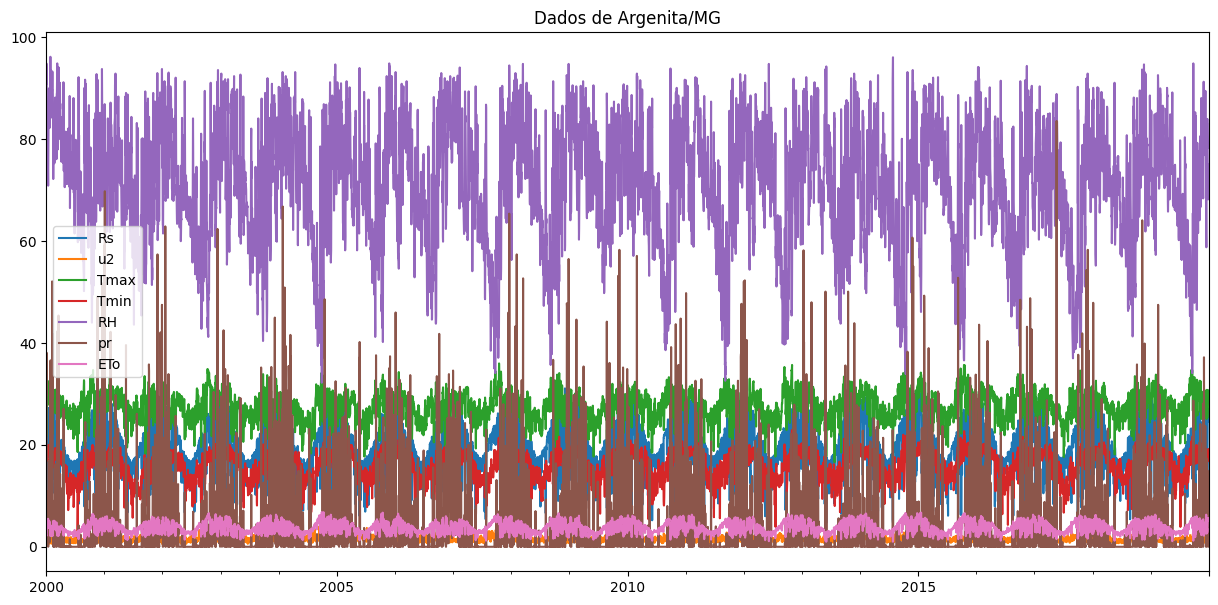

In [82]:
df4.plot(title='Dados de Argenita/MG')
plt.legend(loc='best')
plt.show()

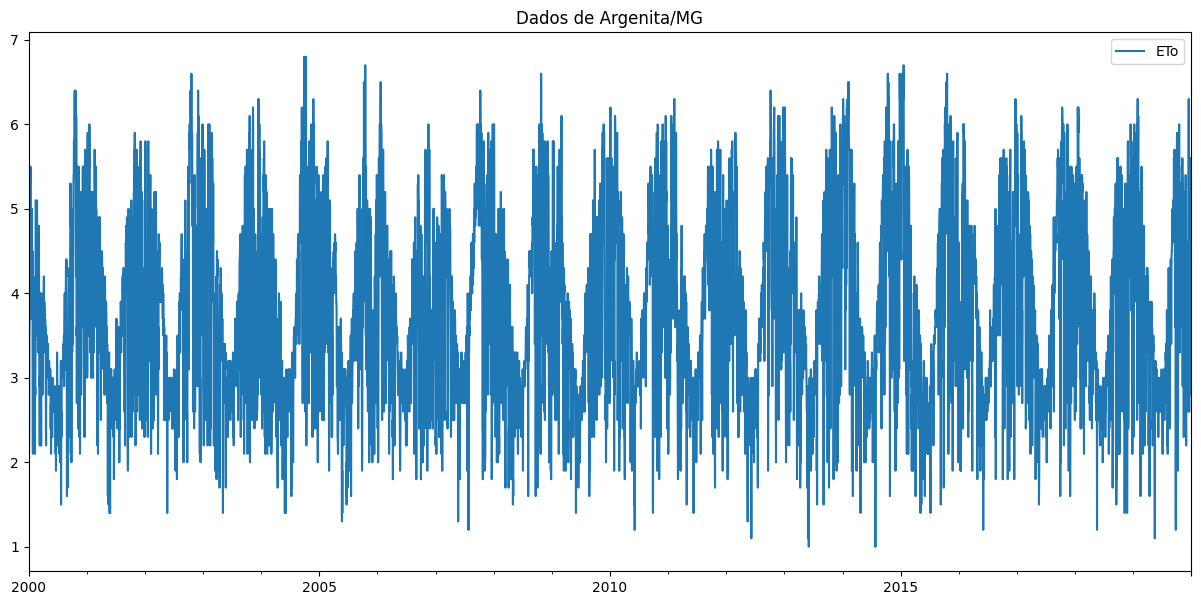

In [83]:
df4['ETo'].plot(title='Dados de Argenita/MG')
plt.legend(loc='best')
plt.show()

In [41]:
df_etos = pd.DataFrame()

df_etos['x1'] = df1['ETo']
df_etos['x2'] = df2['ETo']
df_etos['x3'] = df3['ETo']
df_etos['x4'] = df4['ETo']
df_etos['target'] = df_target['ETo']
df_etos.head()

x1   x2   x3   x4  target
2000-01-01  2.1  2.3  2.2  2.3     2.2
2000-01-02  2.2  2.7  2.0  2.3     2.4
2000-01-03  3.1  3.6  2.1  2.1     2.6
2000-01-04  2.9  3.1  2.4  2.2     2.8
2000-01-05  4.9  4.9  3.9  2.5     4.7

In [42]:
df_etos.describe()

x1           x2           x3           x4       target
count  7305.000000  7305.000000  7305.000000  7305.000000  7305.000000
mean      4.062368     3.533593     3.217180     3.765270     3.895592
std       1.145331     1.228129     1.136878     1.085725     1.165992
min       1.400000     1.100000     0.800000     1.000000     1.000000
25%       3.100000     2.500000     2.300000     2.900000     2.900000
50%       3.900000     3.300000     3.100000     3.600000     3.700000
75%       4.900000     4.500000     4.000000     4.600000     4.800000
max       7.800000     7.400000     6.800000     6.800000     7.000000

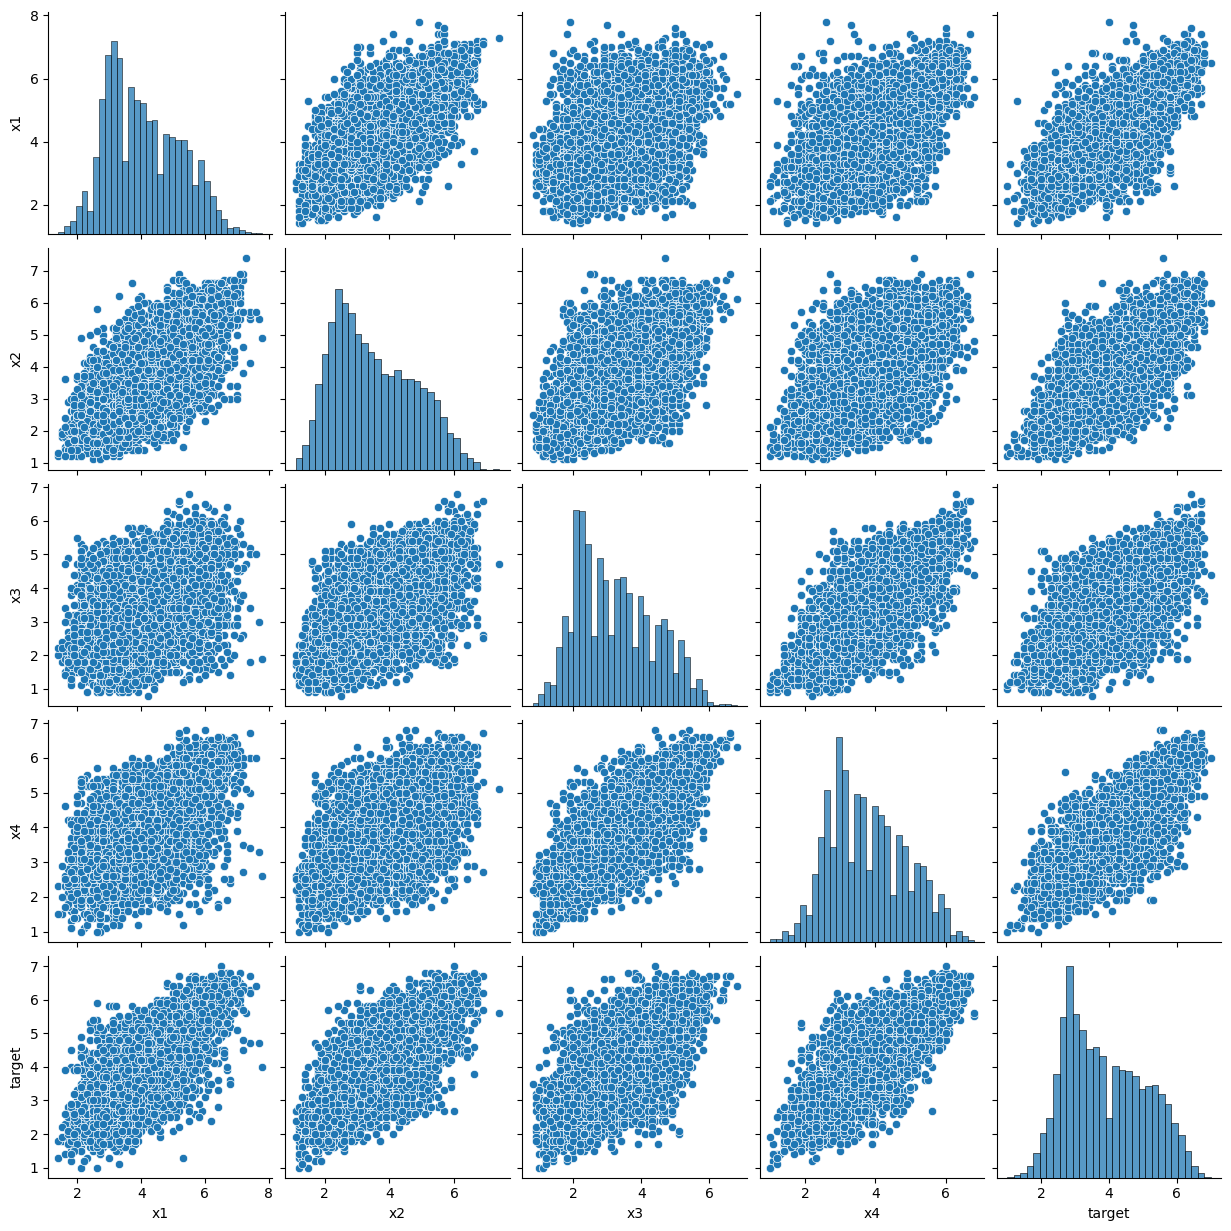

In [86]:
sns.pairplot(df_etos)

In [43]:
fields = ['x1','x2','x3', 'x4', 'target'] # mdct is datetime 
x = df_etos[fields]
x.head(10)

x1   x2   x3   x4  target
2000-01-01  2.1  2.3  2.2  2.3     2.2
2000-01-02  2.2  2.7  2.0  2.3     2.4
2000-01-03  3.1  3.6  2.1  2.1     2.6
2000-01-04  2.9  3.1  2.4  2.2     2.8
2000-01-05  4.9  4.9  3.9  2.5     4.7
2000-01-06  4.9  5.1  4.9  3.5     5.5
2000-01-07  5.2  5.3  5.2  3.8     5.7
2000-01-08  4.9  4.3  5.4  5.3     5.5
2000-01-09  5.4  2.8  5.9  5.2     5.5
2000-01-10  5.0  4.6  5.6  5.3     5.8

In [88]:
NON_DER = []
df_new = df_derived_by_shift(x, 4, NON_DER)

In [89]:
df_new.head()

x1   x2   x3   x4  target  x1_1  x1_2  x1_3  x1_4  x2_1  ...  \
2000-01-01  2.1  2.3  2.2  2.3     2.2   NaN   NaN   NaN   NaN   NaN  ...   
2000-01-02  2.2  2.7  2.0  2.3     2.4   2.1   NaN   NaN   NaN   2.3  ...   
2000-01-03  3.1  3.6  2.1  2.1     2.6   2.2   2.1   NaN   NaN   2.7  ...   
2000-01-04  2.9  3.1  2.4  2.2     2.8   3.1   2.2   2.1   NaN   3.6  ...   
2000-01-05  4.9  4.9  3.9  2.5     4.7   2.9   3.1   2.2   2.1   3.1  ...   

            x3_3  x3_4  x4_1  x4_2  x4_3  x4_4  target_1  target_2  target_3  \
2000-01-01   NaN   NaN   NaN   NaN   NaN   NaN       NaN       NaN       NaN   
2000-01-02   NaN   NaN   2.3   NaN   NaN   NaN       2.2       NaN       NaN   
2000-01-03   NaN   NaN   2.3   2.3   NaN   NaN       2.4       2.2       NaN   
2000-01-04   2.2   NaN   2.1   2.3   2.3   NaN       2.6       2.4       2.2   
2000-01-05   2.0   2.2   2.2   2.1   2.3   2.3       2.8       2.6       2.4   

            target_4  
2000-01-01       NaN  
2000-01-02       NaN  
2000-01-03       NaN  
2000-01-04       NaN  
2000-01-05       2.2  

[5 rows x 25 columns]

In [91]:
df_new = df_new.dropna()

In [92]:
df_new.head()

x1   x2   x3   x4  target  x1_1  x1_2  x1_3  x1_4  x2_1  ...  \
2000-01-05  4.9  4.9  3.9  2.5     4.7   2.9   3.1   2.2   2.1   3.1  ...   
2000-01-06  4.9  5.1  4.9  3.5     5.5   4.9   2.9   3.1   2.2   4.9  ...   
2000-01-07  5.2  5.3  5.2  3.8     5.7   4.9   4.9   2.9   3.1   5.1  ...   
2000-01-08  4.9  4.3  5.4  5.3     5.5   5.2   4.9   4.9   2.9   5.3  ...   
2000-01-09  5.4  2.8  5.9  5.2     5.5   4.9   5.2   4.9   4.9   4.3  ...   

            x3_3  x3_4  x4_1  x4_2  x4_3  x4_4  target_1  target_2  target_3  \
2000-01-05   2.0   2.2   2.2   2.1   2.3   2.3       2.8       2.6       2.4   
2000-01-06   2.1   2.0   2.5   2.2   2.1   2.3       4.7       2.8       2.6   
2000-01-07   2.4   2.1   3.5   2.5   2.2   2.1       5.5       4.7       2.8   
2000-01-08   3.9   2.4   3.8   3.5   2.5   2.2       5.7       5.5       4.7   
2000-01-09   4.9   3.9   5.3   3.8   3.5   2.5       5.5       5.7       5.5   

            target_4  
2000-01-05       2.2  
2000-01-06       2.4  
2000-01-07       2.6  
2000-01-08       2.8  
2000-01-09       4.7  

[5 rows x 25 columns]

In [93]:
df_new.corr()

x1        x2        x3        x4    target      x1_1  \
x1        1.000000  0.779660  0.572394  0.673563  0.818432  0.808354   
x2        0.779660  1.000000  0.700405  0.640360  0.811726  0.677007   
x3        0.572394  0.700405  1.000000  0.793822  0.774858  0.497210   
x4        0.673563  0.640360  0.793822  1.000000  0.844529  0.570686   
target    0.818432  0.811726  0.774858  0.844529  1.000000  0.689353   
x1_1      0.808354  0.677007  0.497210  0.570686  0.689353  1.000000   
x1_2      0.688298  0.582250  0.440292  0.501539  0.587744  0.808304   
x1_3      0.604119  0.522083  0.414338  0.457320  0.526335  0.688223   
x1_4      0.551753  0.488851  0.409969  0.437959  0.495982  0.604109   
x2_1      0.701051  0.784082  0.582797  0.543532  0.685596  0.779600   
x2_2      0.605433  0.650588  0.510284  0.474396  0.583125  0.700914   
x2_3      0.539449  0.578971  0.487843  0.441044  0.526357  0.605346   
x2_4      0.494432  0.543735  0.478477  0.420029  0.495066  0.539432   
x3_1      0.592259  0.721416  0.786957  0.666275  0.717551  0.572260   
x3_2      0.537084  0.642176  0.630271  0.527061  0.595080  0.592142   
x3_3      0.480812  0.569185  0.548417  0.452001  0.516355  0.536941   
x3_4      0.440096  0.522505  0.515298  0.411746  0.469410  0.480677   
x4_1      0.658057  0.642308  0.656966  0.739909  0.739108  0.673517   
x4_2      0.582857  0.565833  0.525570  0.569562  0.595171  0.657984   
x4_3      0.513447  0.492845  0.453505  0.476092  0.503852  0.582808   
x4_4      0.461159  0.448007  0.416872  0.429567  0.449736  0.513344   
target_1  0.748016  0.733317  0.633741  0.674316  0.788732  0.818379   
target_2  0.645322  0.630401  0.530960  0.544038  0.635080  0.747972   
target_3  0.562314  0.551571  0.476539  0.476691  0.544451  0.645316   
target_4  0.507240  0.502079  0.452356  0.442275  0.496099  0.562307   

              x1_2      x1_3      x1_4      x2_1  ...      x3_3      x3_4  \
x1        0.688298  0.604119  0.551753  0.701051  ...  0.480812  0.440096   
x2        0.582250  0.522083  0.488851  0.784082  ...  0.569185  0.522505   
x3        0.440292  0.414338  0.409969  0.582797  ...  0.548417  0.515298   
x4        0.501539  0.457320  0.437959  0.543532  ...  0.452001  0.411746   
target    0.587744  0.526335  0.495982  0.685596  ...  0.516355  0.469410   
x1_1      0.808304  0.688223  0.604109  0.779600  ...  0.536941  0.480677   
x1_2      1.000000  0.808232  0.688187  0.676932  ...  0.592017  0.536820   
x1_3      0.808232  1.000000  0.808281  0.582110  ...  0.572020  0.591912   
x1_4      0.688187  0.808281  1.000000  0.521972  ...  0.496922  0.571991   
x2_1      0.676932  0.582110  0.521972  1.000000  ...  0.642084  0.569084   
x2_2      0.779500  0.676709  0.581903  0.784028  ...  0.721210  0.641944   
x2_3      0.700850  0.779421  0.676649  0.650519  ...  0.700134  0.721150   
x2_4      0.605326  0.700862  0.779416  0.578911  ...  0.582550  0.700130   
x3_1      0.497059  0.440119  0.414270  0.700338  ...  0.630130  0.548277   
x3_2      0.572138  0.496930  0.440097  0.721346  ...  0.786805  0.630022   
x3_3      0.592017  0.572020  0.496922  0.642084  ...  1.000000  0.786741   
x3_4      0.536820  0.591912  0.571991  0.569084  ...  0.786741  1.000000   
x4_1      0.570611  0.501531  0.457391  0.640252  ...  0.526985  0.451915   
x4_2      0.673431  0.570581  0.501598  0.642185  ...  0.666135  0.526878   
x4_3      0.657929  0.673430  0.570630  0.565730  ...  0.793686  0.666086   
x4_4      0.582708  0.657888  0.673463  0.492713  ...  0.656713  0.793629   
target_1  0.689261  0.587621  0.526309  0.811684  ...  0.594925  0.516205   
target_2  0.818340  0.689219  0.587631  0.733242  ...  0.717400  0.594845   
target_3  0.747959  0.818371  0.689256  0.630326  ...  0.774760  0.717390   
target_4  0.645293  0.748004  0.818402  0.551481  ...  0.633651  0.774751   

              x4_1      x4_2      x4_3      x4_4  target_1  target_2  \
x1        0.658057  0.582857  0.513447  0.461159  0.748016  0.645322

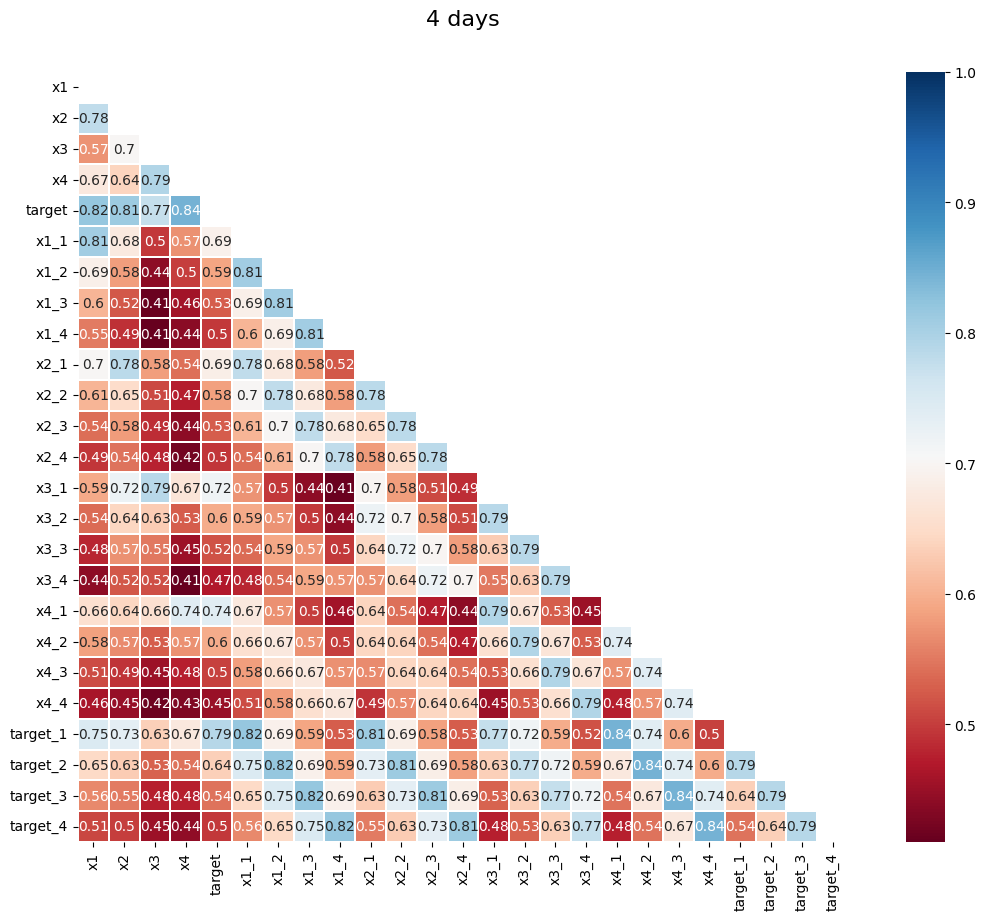

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
plt.title(u'4 days', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

*Do mapa de correlação acima, observa-se uma boa correlação entre as ETo's de Francisco Dumont, Bom Jesus do Galho e Argenita e a ETo de Pará de Minas. Carvalhos apresenta uma correlação um pouco menor.*

In [44]:
# Normalize Data

# Save Min-Max for Denorm
min_raw = df_etos.min()

max_raw = df_etos.max()

# Perform Normalization
norm_df = normalize(df_etos)
df = df_etos

Implementando um modelo VAR(1), com 5 variáveis (ETo's de Francisco Dumonto/MG, Bom Jesus do Galho/MG, Carvalhos/MG, Argenita/MG e Pará de Minas/MG):

* $y_{1,t} = c_1 + \phi_{11, 1}*y_{1,t-1} + \phi_{12,1}*y_{2,t-1} + \phi_{13,1}*y_{3,t-1} + \phi_{14,1}*y_{4,t-1} + \phi_{15,1}*y_{5,t-1} + \epsilon_{1,t}$

* $y_{2,t} = c_2 + \phi_{21, 1}*y_{1,t-1} + \phi_{22,1}*y_{2,t-1} + \phi_{23,1}*y_{3,t-1} + \phi_{24,1}*y_{4,t-1} + \phi_{25,1}*y_{5,t-1} + \epsilon_{2,t}$

* $y_{3,t} = c_2 + \phi_{31, 1}*y_{1,t-1} + \phi_{32,1}*y_{2,t-1} + \phi_{33,1}*y_{3,t-1} + \phi_{34,1}*y_{4,t-1} + \phi_{35,1}*y_{5,t-1} + \epsilon_{3,t}$

...

* $y_{5,t} = c_2 + \phi_{51, 1}*y_{1,t-1} + \phi_{52,1}*y_{2,t-1} + \phi_{53,1}*y_{3,t-1} + \phi_{54,1}*y_{4,t-1} + \phi_{55,1}*y_{5,t-1} + \epsilon_{5,t}$

In [45]:
# Separando a base de dados em treinamento e teste, na proporção de 80% para 20%.

# X = df_target['ETo'].values
size = int(len(norm_df) * 0.80)
train, test = norm_df[0:size], norm_df[size:len(norm_df)]

# Modelo VAR.

order = 3
model = VAR(train.values)
model_fit = model.fit(maxlags=order)
lag_order = model_fit.k_ar

print(f'lag_order = {lag_order}\n')
print(model_fit.summary())

lag_order = 3

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 11, Dec, 2023
Time:                     22:35:40
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -24.0400
Nobs:                     5841.00    HQIC:                  -24.0996
Log likelihood:           29115.6    FPE:                3.31034e-11
AIC:                     -24.1314    Det(Omega_mle):     3.26537e-11
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.038429         0.003985            9.643           0.000
L1.y1         0.497902         0.016742           29.740           0.000
L1.y2         0.126919         0.014987            8.469           0.000
L1.y3  

In [46]:
fc = model_fit.forecast(y=test.values, steps=3) # desnormalizar!!! prevendo 3 passos à frente para todas as variáveis.
# print(f'{fc}')
dfc = denormalize(fc, min_raw, max_raw)

In [49]:
# Aplicando a previsão aos dados, usando rolling forecasting.

order = 1

history = [x for x in train]
predictions = []

for t in range(len(test)):
	model = VAR(train.values)
	model_fit = model.fit(maxlags=order)
	fc = model_fit.forecast(y=test[:t+1].values, steps=1)
	output = fc[0][4]
	yhat = output
	predictions.append(yhat)
	obs = test['target'].iloc[t]
	history.append(obs)
	if t < 3 or t >= (len(test) - 3):
		print('previsão=%f, osbervado=%f' % (yhat, obs))

previsão=0.731906, osbervado=0.716667
previsão=0.532807, osbervado=0.433333
previsão=0.368967, osbervado=0.316667
previsão=0.743142, osbervado=0.683333
previsão=0.764702, osbervado=0.766667
previsão=0.777312, osbervado=0.850000


In [50]:
# Medindo o desempenho do modelo a partir das métricas: MAE, RMSE e MAPE

mae_var_ext = mean_absolute_error(test['target'], predictions)
print('Test MAE: %.3f' % mae_var_ext)

rmse_var_ext = sqrt(mean_squared_error(test['target'], predictions))
print('Test RMSE: %.3f' % rmse_var_ext)

mape_var_ext = mean_absolute_percentage_error(test['target'], predictions)
print('Test MAPE: %.3f' % mape_var_ext)

Test MAE: 0.052
Test RMSE: 0.067
Test MAPE: 0.144


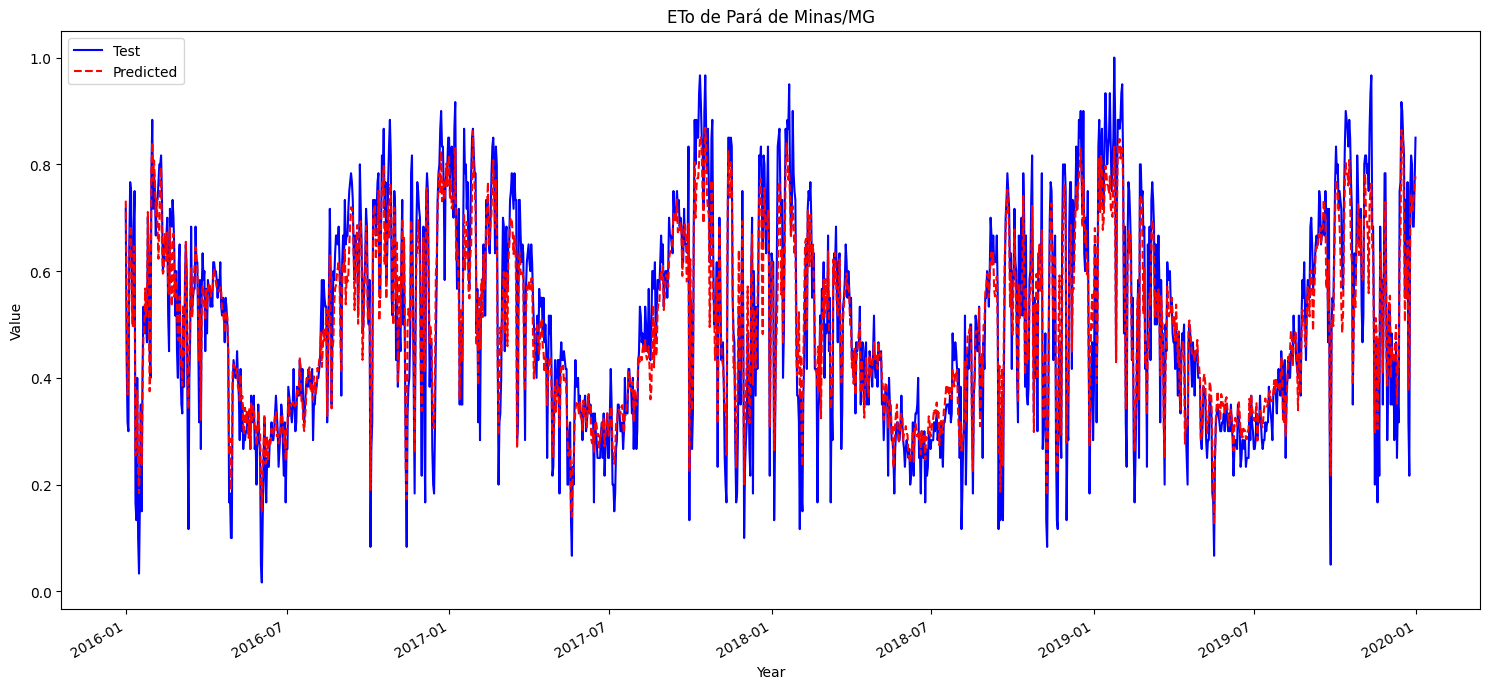

In [51]:
fig, ax = plt.subplots()

ax.plot(df_target['ETo'].index[size:len(df_target)], test['target'], 'b-', label='Test')
ax.plot(df_target['ETo'].index[size:len(df_target)], predictions, 'r--', label='Predicted')

ax.legend(loc='best')

ax.set_xlabel('Year')
ax.set_ylabel('Value')

# ax.axvline(df_target['ETo'].index[size], color='#808080', linestyle='-', alpha=0.2)
# ax.axvline(df_target['ETo'].index[len(X) - 1], color='#808080', linestyle='-', alpha=0.2)
# ax.axvspan(df_target['ETo'].index[size], df_target['ETo'].index[len(df_target) - 1], color='#808080', alpha=0.2) # zona cinza

plt.title("ETo de Pará de Minas/MG")

fig.autofmt_xdate()
plt.tight_layout()

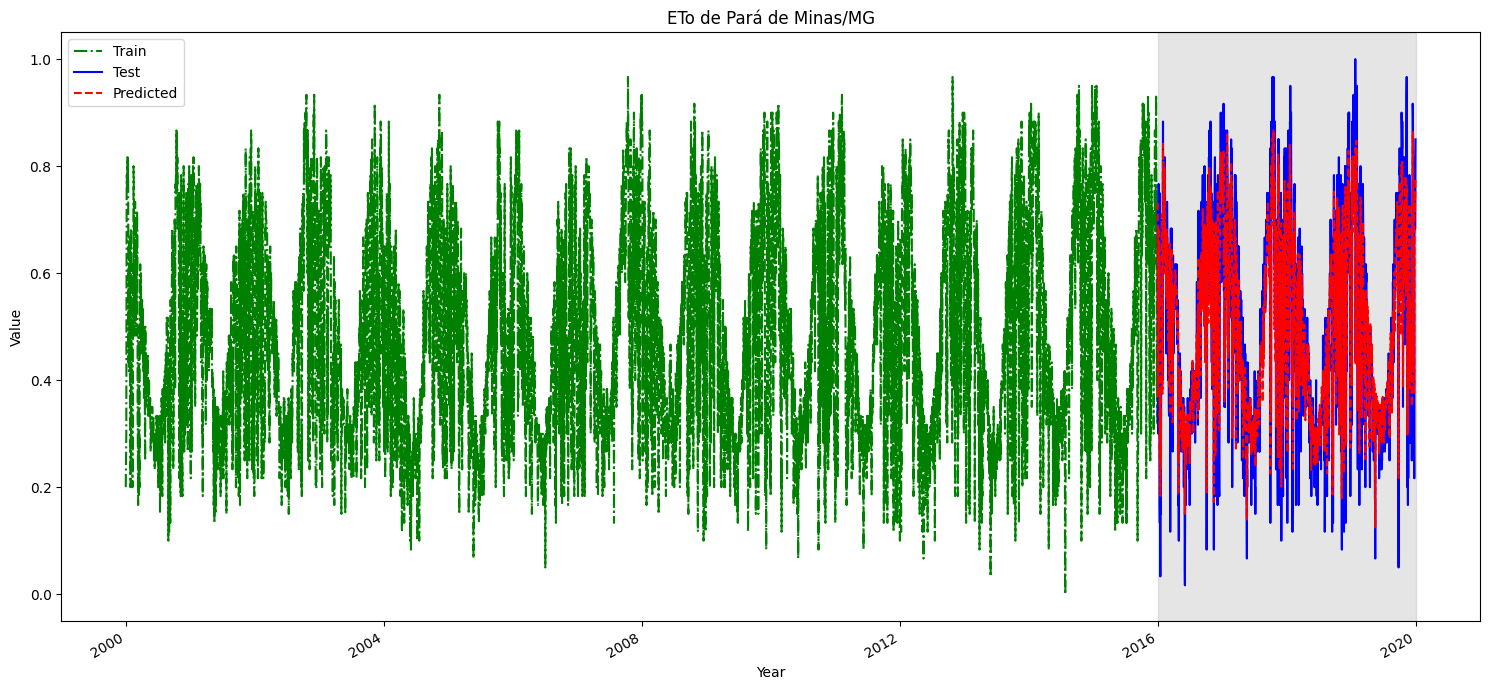

In [52]:
# Ilustrando graficamente o desempenho do modelo ARIMA.

fig, ax = plt.subplots()

ax.plot(df_target['ETo'].index[0:size], train['target'], 'g-.', label='Train')
ax.plot(df_target['ETo'].index[size:len(df_target)], test['target'], 'b-', label='Test')
ax.plot(df_target['ETo'].index[size:len(df_target)], predictions, 'r--', label='Predicted')

ax.legend(loc='best')

ax.set_xlabel('Year')
ax.set_ylabel('Value')

# ax.axvline(df_target['ETo'].index[size], color='#808080', linestyle='-', alpha=0.2)
# ax.axvline(df_target['ETo'].index[len(X) - 1], color='#808080', linestyle='-', alpha=0.2)
# ax.axvspan(df_target['ETo'].index[size], df_target['ETo'].index[len(X) - 1], color='#808080', alpha=0.2) # zona cinza

ax.axvspan(df_target['ETo'].index[size], df_target['ETo'].index[len(df_target) - 1], color='#808080', alpha=0.2) # zona cinza


plt.title("ETo de Pará de Minas/MG")

fig.autofmt_xdate()
plt.tight_layout()

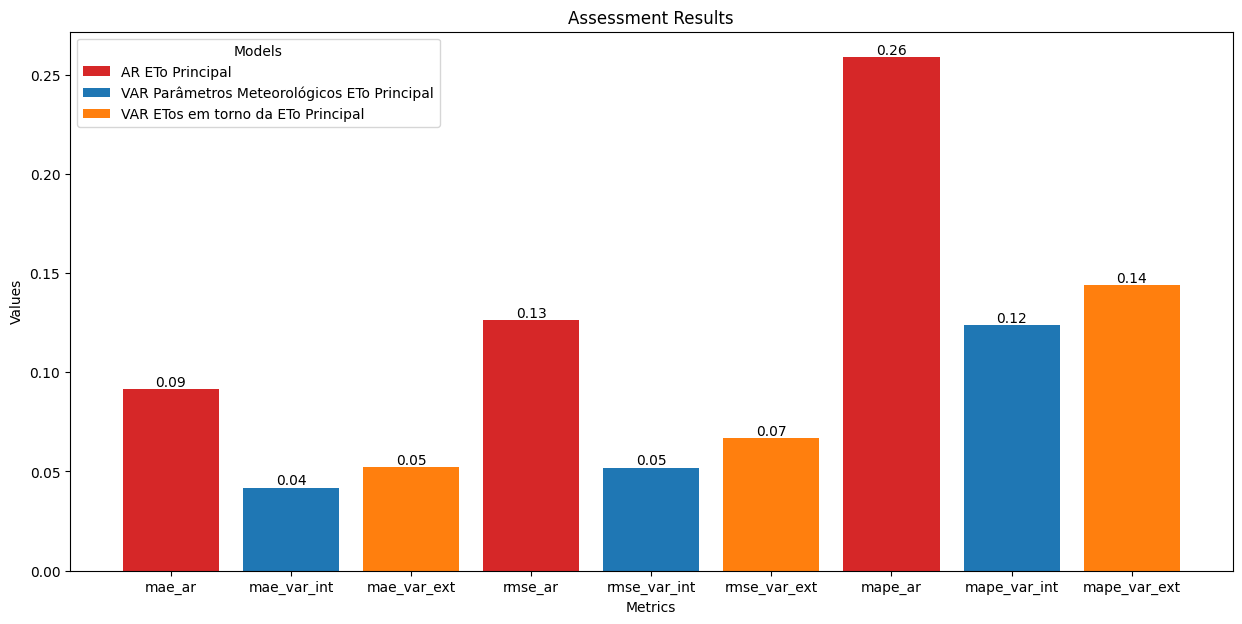

In [53]:
metrics_names = ['mae_ar', 'mae_var_int', 'mae_var_ext', 'rmse_ar', 'rmse_var_int', 'rmse_var_ext', 'mape_ar', 'mape_var_int', 'mape_var_ext']
metrics_values = [mae_ar, mae_var_int, mae_var_ext, rmse_ar, rmse_var_int, rmse_var_ext, mape_ar,   mape_var_int,   mape_var_ext]
colors = ['tab:red', 'tab:blue', 'tab:orange']
bar_labels = ['AR ETo Principal', 'VAR Parâmetros Meteorológicos ETo Principal', 'VAR ETos em torno da ETo Principal', '_AR ETo Principal', '_VAR Parâmetros Meteorológicos ETo Principal', '_VAR ETos em torno da ETo Principal', '_AR ETo Principal', '_VAR Parâmetros Meteorológicos ETo Principal', '_VAR ETos em torno da ETo Principal']

fig, ax = plt.subplots()

bar_container = ax.bar(metrics_names, metrics_values, color=colors, label=bar_labels)
ax.set(ylabel='Values', xlabel='Metrics', title='Assessment Results') #, ylim=(0, 100))
ax.bar_label(bar_container, fmt='{:,.2f}')
ax.legend(title='Models')

**Considerações:** Observa-se, em todas as métricas utilizadas, que o modelo de previsão multivariado, VAR, que utiliza as variáveis "internas" (Rs, u2, Tmax, Tmin, RH, pr) da base principal (Pará de Minas/MG) para prever a ETo teve o melhor desempenho. O modelo multivariado que utiliza as séries de ETo das outras bases selecionadas (Francisco Dumont/MG, Bom Jesus do Galho/MG, Carvalhos/MG e Argenita/MG), para prever a ETo da base principal (Pará de Minas/MG), teve desempenho ligeiramente inferior. O modelo univariado, AR, de ordem 1, foi o que apresentou pior desempenho.